# Projet IPEO

### Data loading

In [1]:
import os
import random
from collections import defaultdict

import torch
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import matplotlib.pyplot as plt
import numpy as np

✓ Data augmentation activée pour le training
Device utilisé : cuda
Classes : ['damage', 'no_damage']
Nombre d'images (train) : 19000
Nombre d'images (val) : 2000
Nombre d'images (test) : 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8737547..5.174828].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6838293..2.127617].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7471378..5.3940105].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0953345..3.79711].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6205208..4.454657].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0953345..5.7071285].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5759305..5.0808926].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0953345..5.174828].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0953345..3.3900568].


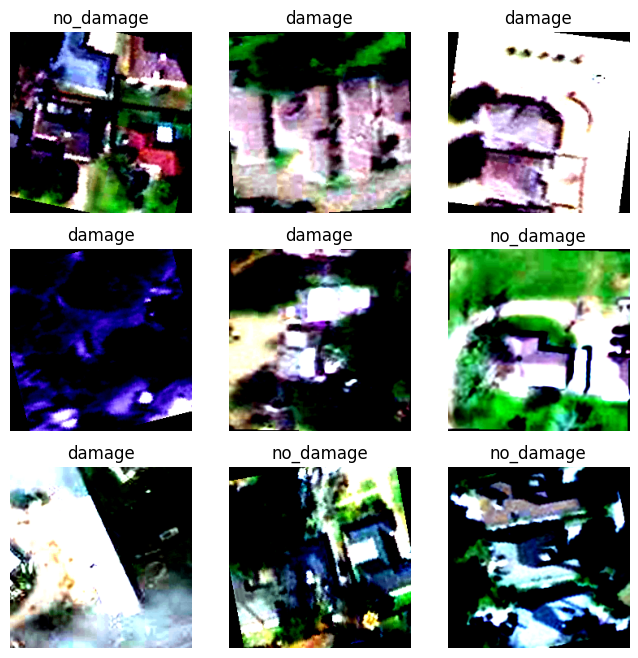

In [2]:
base_dir = "ipeo_hurricane_for_students"

mean = torch.tensor([0.3520655930042267, 0.3834735155105591, 0.28522437810897827])
std = torch.tensor([0.14353738725185394, 0.12388758361339569, 0.12524260580539703])

normalize = T.Normalize(mean, std)

# Transform AVEC augmentation AGRESSIVE (pour training)
transforms_train = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.RandomGrayscale(p=0.1),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
    T.ToTensor(),
    normalize
])

# Transform SANS augmentation (pour validation/test)
transforms_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])

print("✓ Data augmentation activée pour le training")

train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transforms_train)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=transforms_val)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transforms_val)

# Détection du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)


# Ajustements DataLoader pour macOS : num_workers=0 pour éviter "Broken pipe" (2 sinon)
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=0, pin_memory=False)

print("Classes :", train_ds.classes)
print("Nombre d'images (train) :", len(train_ds))
print("Nombre d'images (val) :", len(val_ds))
print("Nombre d'images (test) :", len(test_ds))

def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for img, label, ax in zip(images[:9], labels[:9], axes.flat):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(train_ds.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_loader)

### Model loading

In [3]:
from torchvision.models import resnet34

# load a resnet34 with 2 classes (damage vs no_damage) and move to device
model = resnet34(num_classes=2).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss function with Class Balancing

In [4]:
# Compute class weights to handle imbalanced dataset
from collections import Counter

def compute_class_weights(dataset, device):
    """Calcule les poids pour chaque classe (inverse de la fréquence)"""
    # Compter les occurrences de chaque classe
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    
    # Calculer les poids (inverse de la fréquence)
    total_samples = len(labels)
    num_classes = len(class_counts)
    class_weights = torch.zeros(num_classes)
    
    for class_id, count in class_counts.items():
        class_weights[class_id] = total_samples / (num_classes * count)
    
    return class_weights.to(device)

# Calculer les class weights sur le training set
class_weights = compute_class_weights(train_ds, device)
print(f"✓ Class weights computed:")
for i, weight in enumerate(class_weights):
    print(f"   Class {train_ds.classes[i]}: {weight:.4f}")

# Define the loss function with class weights
criterion = CrossEntropyLoss(weight=class_weights)

✓ Class weights computed:
   Class damage: 0.7308
   Class no_damage: 1.5833


### Optimizer

In [5]:
from torch.optim import SGD

learning_rate = 0.01

optimizer = SGD(model.parameters(),lr=learning_rate)

### Training step

In [6]:
import torch.nn.functional as F

def training_step(batch, model, optimizer, device):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = y_hat.argmax(1).cpu().detach().numpy()
    gt = y.cpu().detach().numpy()
    accuracy = (preds == gt).mean()

    return loss.item(), float(accuracy)


### Training and validating over the full batch

In [7]:
import numpy as np

def train_epoch(train_dl, model, optimizer, device):

    # collect some statistics
    losses, accuracies = [], []
    total_batches = len(train_dl)
    print(f"Training: {total_batches} batches to process")

    for batch_idx, batch in enumerate(train_dl, 1):
        loss, accuracy = training_step(batch, model, optimizer, device)

        # append statistics (loss is a float already)
        losses.append(loss)
        accuracies.append(accuracy)
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"  Batch {batch_idx}/{total_batches} - loss: {loss:.4f}, acc: {accuracy*100:.2f}%")

    # protections si listes vides
    if len(losses) == 0:
        return 0.0, 0.0

    # return averaged losses and accuracies
    return float(np.mean(losses)), float(np.mean(accuracies))


def validate_epoch(val_dl, model, device):
    """Évalue le modèle sur l'ensemble de validation (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():  # pas de gradient pour la validation
        for batch in val_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))

In [8]:
num_epochs = 50  # Augmentez à 50, early stopping arrêtera avant si nécessaire
import os
import json

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# ============ EARLY STOPPING CONFIGURATION ============
patience = 5  # Nombre d'epochs sans amélioration avant d'arrêter
min_delta = 0.001  # Amélioration minimale considérée (0.1%)
# ====================================================

# Vérifier si les modèles ET les stats existent
models_exist = (os.path.exists("models/resnet_final.pth") and 
                os.path.exists("models/stats.json"))

if models_exist:
    # Charger les modèles (map_location pour compatibilité CPU/GPU)
    model.load_state_dict(torch.load("models/resnet_final.pth", map_location=device))
    print("✅ ResNet34 loaded from models/resnet_final.pth")
    
    # Charger les stats
    with open("models/stats.json", "r") as f:
        saved_stats = json.load(f)
        stats_resnet = saved_stats["resnet"]
    print("✅ Stats loaded from models/stats.json")
    print("\n⏭️ TRAINING SKIPPED - using pre-trained models and stats")
    train_models = False
else:
    print("🔄 Starting training (models or stats not found)...")
    print(f"⚙️  Early stopping enabled: patience={patience} epochs, min_delta={min_delta*100:.1f}%")
    print("✓ Data augmentation activée")
    train_models = True

# ENTRAÎNER SEULEMENT SI LES MODÈLES N'EXISTENT PAS
if train_models:
    # ============ TRAINING RESNET34 WITH DATA AUGMENTATION ============
    print(f"\n{'='*80}")
    print("TRAINING RESNET34 WITH EARLY STOPPING & DATA AUGMENTATION")
    print(f"{'='*80}")
    
    stats_resnet = []
    best_val_acc_resnet = 0
    patience_counter_resnet = 0
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"RESNET34 - Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        trainloss_resnet, trainaccuracy_resnet = train_epoch(train_loader, model, optimizer, device)
        valloss_resnet, valaccuracy_resnet = validate_epoch(val_loader, model, device)

        print(f"epoch {epoch}; trainloss {trainloss_resnet:.4f}, train accuracy {trainaccuracy_resnet*100:.2f}% | valloss {valloss_resnet:.4f}, val accuracy {valaccuracy_resnet*100:.2f}%")

        stats_resnet.append({
            "trainloss": float(trainloss_resnet),
            "trainaccuracy": float(trainaccuracy_resnet),
            "valloss": float(valloss_resnet),
            "valaccuracy": float(valaccuracy_resnet),
            "epoch": epoch
        })

        # ====== EARLY STOPPING LOGIC ======
        if valaccuracy_resnet > best_val_acc_resnet + min_delta:
            best_val_acc_resnet = valaccuracy_resnet
            patience_counter_resnet = 0
            # Sauvegarder le meilleur modèle
            torch.save(model.state_dict(), "models/resnet_final.pth")
            print(f"✅ New best val accuracy: {best_val_acc_resnet*100:.2f}% - Model saved!")
        else:
            patience_counter_resnet += 1
            print(f"⏱️  No improvement. Patience: {patience_counter_resnet}/{patience}")
            
            if patience_counter_resnet >= patience:
                print(f"\n🛑 Early stopping triggered! No improvement for {patience} epochs.")
                print(f"   Best validation accuracy: {best_val_acc_resnet*100:.2f}%")
                break
        # ==================================

    print("✅ ResNet34 training completed (or early stopped)")
    
    # Save stats as JSON
    with open("models/stats.json", "w") as f:
        json.dump({"resnet": stats_resnet}, f)
    print("✅ Stats saved to models/stats.json")
else:
    print("\n⏭️ TRAINING SKIPPED - using pre-trained models and stats")

🔄 Starting training (models or stats not found)...
⚙️  Early stopping enabled: patience=5 epochs, min_delta=0.1%
✓ Data augmentation activée

TRAINING RESNET34 WITH EARLY STOPPING & DATA AUGMENTATION

RESNET34 - Epoch 1/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.5442, acc: 75.00%


  Batch 20/1188 - loss: 1.1973, acc: 43.75%


  Batch 30/1188 - loss: 1.0448, acc: 37.50%


  Batch 40/1188 - loss: 0.9677, acc: 62.50%


  Batch 50/1188 - loss: 0.6138, acc: 75.00%


  Batch 60/1188 - loss: 0.6003, acc: 56.25%


  Batch 70/1188 - loss: 0.8150, acc: 43.75%


  Batch 80/1188 - loss: 1.0567, acc: 75.00%


  Batch 90/1188 - loss: 0.9572, acc: 68.75%


  Batch 100/1188 - loss: 0.7665, acc: 68.75%


  Batch 110/1188 - loss: 0.3669, acc: 93.75%


  Batch 120/1188 - loss: 0.4847, acc: 75.00%


  Batch 130/1188 - loss: 0.3328, acc: 87.50%


  Batch 140/1188 - loss: 1.2254, acc: 68.75%


  Batch 150/1188 - loss: 0.2775, acc: 93.75%


  Batch 160/1188 - loss: 0.1429, acc: 93.75%


  Batch 170/1188 - loss: 0.8387, acc: 75.00%


  Batch 180/1188 - loss: 0.4155, acc: 87.50%


  Batch 190/1188 - loss: 0.3271, acc: 87.50%


  Batch 200/1188 - loss: 0.7953, acc: 75.00%


  Batch 210/1188 - loss: 0.4327, acc: 75.00%


  Batch 220/1188 - loss: 0.6743, acc: 62.50%


  Batch 230/1188 - loss: 0.5842, acc: 93.75%


  Batch 240/1188 - loss: 0.2477, acc: 87.50%


  Batch 250/1188 - loss: 0.0751, acc: 100.00%


  Batch 260/1188 - loss: 0.4510, acc: 81.25%


  Batch 270/1188 - loss: 0.3410, acc: 93.75%


  Batch 280/1188 - loss: 0.2489, acc: 87.50%


  Batch 290/1188 - loss: 0.2648, acc: 87.50%


  Batch 300/1188 - loss: 0.1147, acc: 100.00%


  Batch 310/1188 - loss: 0.4622, acc: 81.25%


  Batch 320/1188 - loss: 0.5287, acc: 75.00%


  Batch 330/1188 - loss: 0.6220, acc: 81.25%


  Batch 340/1188 - loss: 0.6151, acc: 68.75%


  Batch 350/1188 - loss: 0.3505, acc: 81.25%


  Batch 360/1188 - loss: 0.1553, acc: 100.00%


  Batch 370/1188 - loss: 1.0647, acc: 62.50%


  Batch 380/1188 - loss: 0.5839, acc: 87.50%


  Batch 390/1188 - loss: 0.4647, acc: 87.50%


  Batch 400/1188 - loss: 0.1299, acc: 93.75%


  Batch 410/1188 - loss: 0.2876, acc: 81.25%


  Batch 420/1188 - loss: 0.2663, acc: 87.50%


  Batch 430/1188 - loss: 0.3427, acc: 81.25%


  Batch 440/1188 - loss: 0.2101, acc: 87.50%


  Batch 450/1188 - loss: 0.2452, acc: 93.75%


  Batch 460/1188 - loss: 0.1317, acc: 100.00%


  Batch 470/1188 - loss: 0.1078, acc: 100.00%


  Batch 480/1188 - loss: 0.2259, acc: 93.75%


  Batch 490/1188 - loss: 1.0142, acc: 68.75%


  Batch 500/1188 - loss: 0.4016, acc: 81.25%


  Batch 510/1188 - loss: 0.0771, acc: 100.00%


  Batch 520/1188 - loss: 0.4948, acc: 75.00%


  Batch 530/1188 - loss: 0.2218, acc: 87.50%


  Batch 540/1188 - loss: 0.1390, acc: 93.75%


  Batch 550/1188 - loss: 0.1387, acc: 93.75%


  Batch 560/1188 - loss: 0.4093, acc: 75.00%


  Batch 570/1188 - loss: 0.1270, acc: 93.75%


  Batch 580/1188 - loss: 0.3989, acc: 68.75%


  Batch 590/1188 - loss: 0.3977, acc: 81.25%


  Batch 600/1188 - loss: 0.2146, acc: 87.50%


  Batch 610/1188 - loss: 0.4142, acc: 87.50%


  Batch 620/1188 - loss: 0.1306, acc: 93.75%


  Batch 630/1188 - loss: 0.1598, acc: 93.75%


  Batch 640/1188 - loss: 0.3338, acc: 93.75%


  Batch 650/1188 - loss: 0.5335, acc: 81.25%


  Batch 660/1188 - loss: 0.2176, acc: 93.75%


  Batch 670/1188 - loss: 0.1462, acc: 100.00%


  Batch 680/1188 - loss: 0.2183, acc: 87.50%


  Batch 690/1188 - loss: 0.3874, acc: 87.50%


  Batch 700/1188 - loss: 0.1634, acc: 93.75%


  Batch 710/1188 - loss: 0.7491, acc: 81.25%


  Batch 720/1188 - loss: 0.1129, acc: 100.00%


  Batch 730/1188 - loss: 0.0580, acc: 100.00%


  Batch 740/1188 - loss: 0.2625, acc: 87.50%


  Batch 750/1188 - loss: 0.4949, acc: 93.75%


  Batch 760/1188 - loss: 0.2930, acc: 81.25%


  Batch 770/1188 - loss: 0.2218, acc: 87.50%


  Batch 780/1188 - loss: 0.0833, acc: 100.00%


  Batch 790/1188 - loss: 0.1950, acc: 87.50%


  Batch 800/1188 - loss: 1.6823, acc: 56.25%


  Batch 810/1188 - loss: 0.1633, acc: 93.75%


  Batch 820/1188 - loss: 0.1242, acc: 100.00%


  Batch 830/1188 - loss: 0.7328, acc: 87.50%


  Batch 840/1188 - loss: 0.3171, acc: 87.50%


  Batch 850/1188 - loss: 0.1197, acc: 93.75%


  Batch 860/1188 - loss: 0.1552, acc: 81.25%


  Batch 870/1188 - loss: 0.2382, acc: 93.75%


  Batch 880/1188 - loss: 0.1977, acc: 87.50%


  Batch 890/1188 - loss: 0.6544, acc: 62.50%


  Batch 900/1188 - loss: 0.1804, acc: 87.50%


  Batch 910/1188 - loss: 0.1388, acc: 87.50%


  Batch 920/1188 - loss: 0.2682, acc: 93.75%


  Batch 930/1188 - loss: 0.3004, acc: 87.50%


  Batch 940/1188 - loss: 0.2158, acc: 87.50%


  Batch 950/1188 - loss: 0.1673, acc: 87.50%


  Batch 960/1188 - loss: 0.7880, acc: 56.25%


  Batch 970/1188 - loss: 0.1545, acc: 93.75%


  Batch 980/1188 - loss: 0.1667, acc: 93.75%


  Batch 990/1188 - loss: 0.1972, acc: 87.50%


  Batch 1000/1188 - loss: 0.1192, acc: 93.75%


  Batch 1010/1188 - loss: 0.1365, acc: 87.50%


  Batch 1020/1188 - loss: 0.4744, acc: 93.75%


  Batch 1030/1188 - loss: 0.1816, acc: 93.75%


  Batch 1040/1188 - loss: 0.1932, acc: 87.50%


  Batch 1050/1188 - loss: 0.3260, acc: 87.50%


  Batch 1060/1188 - loss: 0.2396, acc: 93.75%


  Batch 1070/1188 - loss: 0.2708, acc: 93.75%


  Batch 1080/1188 - loss: 0.0864, acc: 100.00%


  Batch 1090/1188 - loss: 0.6354, acc: 62.50%


  Batch 1100/1188 - loss: 0.1714, acc: 93.75%


  Batch 1110/1188 - loss: 0.1433, acc: 93.75%


  Batch 1120/1188 - loss: 0.3141, acc: 87.50%


  Batch 1130/1188 - loss: 0.3124, acc: 93.75%


  Batch 1140/1188 - loss: 0.4508, acc: 93.75%


  Batch 1150/1188 - loss: 0.3125, acc: 75.00%


  Batch 1160/1188 - loss: 0.0681, acc: 100.00%


  Batch 1170/1188 - loss: 0.0868, acc: 100.00%


  Batch 1180/1188 - loss: 0.4503, acc: 81.25%


  Batch 1188/1188 - loss: 0.2910, acc: 87.50%


epoch 0; trainloss 0.4064, train accuracy 84.01% | valloss 0.2347, val accuracy 91.10%
✅ New best val accuracy: 91.10% - Model saved!

RESNET34 - Epoch 2/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0981, acc: 100.00%


  Batch 20/1188 - loss: 0.2829, acc: 87.50%


  Batch 30/1188 - loss: 0.1088, acc: 93.75%


  Batch 40/1188 - loss: 0.5487, acc: 93.75%


  Batch 50/1188 - loss: 0.1992, acc: 93.75%


  Batch 60/1188 - loss: 0.0664, acc: 100.00%


  Batch 70/1188 - loss: 0.4122, acc: 62.50%


  Batch 80/1188 - loss: 0.1324, acc: 100.00%


  Batch 90/1188 - loss: 0.2364, acc: 87.50%


  Batch 100/1188 - loss: 0.1208, acc: 93.75%


  Batch 110/1188 - loss: 0.0851, acc: 93.75%


  Batch 120/1188 - loss: 0.2319, acc: 93.75%


  Batch 130/1188 - loss: 0.3519, acc: 93.75%


  Batch 140/1188 - loss: 0.2659, acc: 93.75%


  Batch 150/1188 - loss: 0.2825, acc: 87.50%


  Batch 160/1188 - loss: 0.5102, acc: 75.00%


  Batch 170/1188 - loss: 0.1094, acc: 93.75%


  Batch 180/1188 - loss: 0.1143, acc: 100.00%


  Batch 190/1188 - loss: 0.1355, acc: 93.75%


  Batch 200/1188 - loss: 0.3211, acc: 87.50%


  Batch 210/1188 - loss: 0.7224, acc: 87.50%


  Batch 220/1188 - loss: 0.1908, acc: 87.50%


  Batch 230/1188 - loss: 0.5157, acc: 81.25%


  Batch 240/1188 - loss: 0.4184, acc: 81.25%


  Batch 250/1188 - loss: 0.4395, acc: 87.50%


  Batch 260/1188 - loss: 0.5444, acc: 81.25%


  Batch 270/1188 - loss: 0.2153, acc: 93.75%


  Batch 280/1188 - loss: 0.1069, acc: 93.75%


  Batch 290/1188 - loss: 0.1048, acc: 100.00%


  Batch 300/1188 - loss: 0.3645, acc: 81.25%


  Batch 310/1188 - loss: 0.2043, acc: 93.75%


  Batch 320/1188 - loss: 0.3434, acc: 81.25%


  Batch 330/1188 - loss: 0.1226, acc: 100.00%


  Batch 340/1188 - loss: 0.1304, acc: 93.75%


  Batch 350/1188 - loss: 0.0780, acc: 93.75%


  Batch 360/1188 - loss: 0.3932, acc: 87.50%


  Batch 370/1188 - loss: 0.2192, acc: 93.75%


  Batch 380/1188 - loss: 0.2176, acc: 87.50%


  Batch 390/1188 - loss: 0.2514, acc: 93.75%


  Batch 400/1188 - loss: 0.4720, acc: 87.50%


  Batch 410/1188 - loss: 0.4657, acc: 87.50%


  Batch 420/1188 - loss: 0.0769, acc: 100.00%


  Batch 430/1188 - loss: 0.3460, acc: 93.75%


  Batch 440/1188 - loss: 0.5432, acc: 81.25%


  Batch 450/1188 - loss: 0.1422, acc: 93.75%


  Batch 460/1188 - loss: 0.7285, acc: 81.25%


  Batch 470/1188 - loss: 0.6376, acc: 87.50%


  Batch 480/1188 - loss: 0.3526, acc: 93.75%


  Batch 490/1188 - loss: 0.2984, acc: 93.75%


  Batch 500/1188 - loss: 0.3797, acc: 81.25%


  Batch 510/1188 - loss: 0.2151, acc: 93.75%


  Batch 520/1188 - loss: 0.9965, acc: 68.75%


  Batch 530/1188 - loss: 0.4223, acc: 81.25%


  Batch 540/1188 - loss: 0.0728, acc: 100.00%


  Batch 550/1188 - loss: 0.0433, acc: 100.00%


  Batch 560/1188 - loss: 0.6810, acc: 93.75%


  Batch 570/1188 - loss: 0.0414, acc: 100.00%


  Batch 580/1188 - loss: 0.1120, acc: 93.75%


  Batch 590/1188 - loss: 0.3146, acc: 87.50%


  Batch 600/1188 - loss: 0.1864, acc: 87.50%


  Batch 610/1188 - loss: 0.1865, acc: 87.50%


  Batch 620/1188 - loss: 0.1625, acc: 87.50%


  Batch 630/1188 - loss: 0.2062, acc: 87.50%


  Batch 640/1188 - loss: 0.3302, acc: 81.25%


  Batch 650/1188 - loss: 0.4520, acc: 87.50%


  Batch 660/1188 - loss: 0.2089, acc: 93.75%


  Batch 670/1188 - loss: 0.3829, acc: 93.75%


  Batch 680/1188 - loss: 0.3504, acc: 87.50%


  Batch 690/1188 - loss: 0.0948, acc: 100.00%


  Batch 700/1188 - loss: 0.1566, acc: 93.75%


  Batch 710/1188 - loss: 0.1262, acc: 100.00%


  Batch 720/1188 - loss: 0.2381, acc: 87.50%


  Batch 730/1188 - loss: 0.1137, acc: 100.00%


  Batch 740/1188 - loss: 0.3504, acc: 87.50%


  Batch 750/1188 - loss: 0.2645, acc: 93.75%


  Batch 760/1188 - loss: 0.1512, acc: 93.75%


  Batch 770/1188 - loss: 0.1853, acc: 93.75%


  Batch 780/1188 - loss: 0.4613, acc: 81.25%


  Batch 790/1188 - loss: 0.1681, acc: 93.75%


  Batch 800/1188 - loss: 0.2149, acc: 87.50%


  Batch 810/1188 - loss: 0.2137, acc: 93.75%


  Batch 820/1188 - loss: 0.1746, acc: 93.75%


  Batch 830/1188 - loss: 0.1598, acc: 93.75%


  Batch 840/1188 - loss: 0.2268, acc: 93.75%


  Batch 850/1188 - loss: 0.2605, acc: 87.50%


  Batch 860/1188 - loss: 0.2455, acc: 87.50%


  Batch 870/1188 - loss: 0.0823, acc: 100.00%


  Batch 880/1188 - loss: 0.0942, acc: 100.00%


  Batch 890/1188 - loss: 0.3053, acc: 87.50%


  Batch 900/1188 - loss: 0.1036, acc: 100.00%


  Batch 910/1188 - loss: 0.1999, acc: 93.75%


  Batch 920/1188 - loss: 0.1140, acc: 100.00%


  Batch 930/1188 - loss: 0.6498, acc: 87.50%


  Batch 940/1188 - loss: 0.2051, acc: 93.75%


  Batch 950/1188 - loss: 0.1050, acc: 100.00%


  Batch 960/1188 - loss: 0.1647, acc: 100.00%


  Batch 970/1188 - loss: 0.1387, acc: 93.75%


  Batch 980/1188 - loss: 0.2463, acc: 93.75%


  Batch 990/1188 - loss: 0.1838, acc: 87.50%


  Batch 1000/1188 - loss: 0.0918, acc: 93.75%


  Batch 1010/1188 - loss: 0.1777, acc: 100.00%


  Batch 1020/1188 - loss: 0.3185, acc: 87.50%


  Batch 1030/1188 - loss: 0.3192, acc: 87.50%


  Batch 1040/1188 - loss: 0.0974, acc: 100.00%


  Batch 1050/1188 - loss: 0.1537, acc: 93.75%


  Batch 1060/1188 - loss: 0.1772, acc: 93.75%


  Batch 1070/1188 - loss: 0.0677, acc: 100.00%


  Batch 1080/1188 - loss: 0.3012, acc: 87.50%


  Batch 1090/1188 - loss: 0.3294, acc: 81.25%


  Batch 1100/1188 - loss: 0.2360, acc: 93.75%


  Batch 1110/1188 - loss: 0.0674, acc: 100.00%


  Batch 1120/1188 - loss: 0.6050, acc: 81.25%


  Batch 1130/1188 - loss: 0.2104, acc: 81.25%


  Batch 1140/1188 - loss: 0.0447, acc: 100.00%


  Batch 1150/1188 - loss: 0.1475, acc: 93.75%


  Batch 1160/1188 - loss: 0.2621, acc: 87.50%


  Batch 1170/1188 - loss: 0.3098, acc: 87.50%


  Batch 1180/1188 - loss: 0.1434, acc: 93.75%


  Batch 1188/1188 - loss: 0.0850, acc: 100.00%


epoch 1; trainloss 0.2627, train accuracy 90.27% | valloss 0.1427, val accuracy 93.70%
✅ New best val accuracy: 93.70% - Model saved!

RESNET34 - Epoch 3/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.3435, acc: 87.50%


  Batch 20/1188 - loss: 0.0451, acc: 100.00%


  Batch 30/1188 - loss: 0.1425, acc: 93.75%


  Batch 40/1188 - loss: 0.5104, acc: 93.75%


  Batch 50/1188 - loss: 0.1975, acc: 93.75%


  Batch 60/1188 - loss: 0.3022, acc: 93.75%


  Batch 70/1188 - loss: 0.1149, acc: 93.75%


  Batch 80/1188 - loss: 0.1490, acc: 93.75%


  Batch 90/1188 - loss: 0.1794, acc: 87.50%


  Batch 100/1188 - loss: 0.2049, acc: 87.50%


  Batch 110/1188 - loss: 0.2599, acc: 81.25%


  Batch 120/1188 - loss: 0.1853, acc: 87.50%


  Batch 130/1188 - loss: 0.0425, acc: 100.00%


  Batch 140/1188 - loss: 0.3136, acc: 81.25%


  Batch 150/1188 - loss: 0.2960, acc: 93.75%


  Batch 160/1188 - loss: 0.1520, acc: 93.75%


  Batch 170/1188 - loss: 0.3549, acc: 75.00%


  Batch 180/1188 - loss: 0.0672, acc: 93.75%


  Batch 190/1188 - loss: 0.0955, acc: 100.00%


  Batch 200/1188 - loss: 0.1831, acc: 100.00%


  Batch 210/1188 - loss: 0.1427, acc: 87.50%


  Batch 220/1188 - loss: 0.3949, acc: 81.25%


  Batch 230/1188 - loss: 0.2374, acc: 87.50%


  Batch 240/1188 - loss: 0.0630, acc: 100.00%


  Batch 250/1188 - loss: 0.1835, acc: 93.75%


  Batch 260/1188 - loss: 0.1949, acc: 93.75%


  Batch 270/1188 - loss: 0.2685, acc: 87.50%


  Batch 280/1188 - loss: 0.3001, acc: 87.50%


  Batch 290/1188 - loss: 0.2666, acc: 87.50%


  Batch 300/1188 - loss: 0.1779, acc: 93.75%


  Batch 310/1188 - loss: 0.2467, acc: 87.50%


  Batch 320/1188 - loss: 0.3825, acc: 81.25%


  Batch 330/1188 - loss: 0.6766, acc: 68.75%


  Batch 340/1188 - loss: 0.0419, acc: 100.00%


  Batch 350/1188 - loss: 0.1720, acc: 93.75%


  Batch 360/1188 - loss: 0.0785, acc: 100.00%


  Batch 370/1188 - loss: 0.2401, acc: 81.25%


  Batch 380/1188 - loss: 0.0451, acc: 100.00%


  Batch 390/1188 - loss: 0.2030, acc: 87.50%


  Batch 400/1188 - loss: 0.0875, acc: 93.75%


  Batch 410/1188 - loss: 0.0408, acc: 100.00%


  Batch 420/1188 - loss: 0.1242, acc: 93.75%


  Batch 430/1188 - loss: 0.0996, acc: 100.00%


  Batch 440/1188 - loss: 0.0547, acc: 100.00%


  Batch 450/1188 - loss: 0.0354, acc: 100.00%


  Batch 460/1188 - loss: 0.0229, acc: 100.00%


  Batch 470/1188 - loss: 0.2885, acc: 81.25%


  Batch 480/1188 - loss: 0.0623, acc: 100.00%


  Batch 490/1188 - loss: 0.1713, acc: 93.75%


  Batch 500/1188 - loss: 0.2729, acc: 87.50%


  Batch 510/1188 - loss: 0.1216, acc: 100.00%


  Batch 520/1188 - loss: 0.2008, acc: 87.50%


  Batch 530/1188 - loss: 0.1430, acc: 93.75%


  Batch 540/1188 - loss: 0.0811, acc: 93.75%


  Batch 550/1188 - loss: 0.4813, acc: 87.50%


  Batch 560/1188 - loss: 0.5526, acc: 68.75%


  Batch 570/1188 - loss: 0.0934, acc: 100.00%


  Batch 580/1188 - loss: 0.2966, acc: 81.25%


  Batch 590/1188 - loss: 0.2466, acc: 87.50%


  Batch 600/1188 - loss: 0.3290, acc: 87.50%


  Batch 610/1188 - loss: 0.1306, acc: 87.50%


  Batch 620/1188 - loss: 0.0652, acc: 100.00%


  Batch 630/1188 - loss: 0.2050, acc: 87.50%


  Batch 640/1188 - loss: 0.1715, acc: 93.75%


  Batch 650/1188 - loss: 0.1426, acc: 93.75%


  Batch 660/1188 - loss: 0.1602, acc: 87.50%


  Batch 670/1188 - loss: 0.2254, acc: 93.75%


  Batch 680/1188 - loss: 0.3910, acc: 87.50%


  Batch 690/1188 - loss: 0.2968, acc: 81.25%


  Batch 700/1188 - loss: 0.0942, acc: 100.00%


  Batch 710/1188 - loss: 0.2281, acc: 93.75%


  Batch 720/1188 - loss: 0.4696, acc: 87.50%


  Batch 730/1188 - loss: 0.1990, acc: 93.75%


  Batch 740/1188 - loss: 0.2384, acc: 87.50%


  Batch 750/1188 - loss: 0.0971, acc: 100.00%


  Batch 760/1188 - loss: 0.1575, acc: 93.75%


  Batch 770/1188 - loss: 0.0447, acc: 100.00%


  Batch 780/1188 - loss: 0.1263, acc: 93.75%


  Batch 790/1188 - loss: 0.0738, acc: 100.00%


  Batch 800/1188 - loss: 0.1452, acc: 93.75%


  Batch 810/1188 - loss: 0.3433, acc: 93.75%


  Batch 820/1188 - loss: 0.1555, acc: 87.50%


  Batch 830/1188 - loss: 0.2153, acc: 87.50%


  Batch 840/1188 - loss: 0.0706, acc: 100.00%


  Batch 850/1188 - loss: 0.5098, acc: 87.50%


  Batch 860/1188 - loss: 0.1651, acc: 87.50%


  Batch 870/1188 - loss: 0.0320, acc: 100.00%


  Batch 880/1188 - loss: 0.2499, acc: 93.75%


  Batch 890/1188 - loss: 0.4595, acc: 81.25%


  Batch 900/1188 - loss: 0.5735, acc: 81.25%


  Batch 910/1188 - loss: 0.3242, acc: 81.25%


  Batch 920/1188 - loss: 0.1076, acc: 93.75%


  Batch 930/1188 - loss: 0.0425, acc: 100.00%


  Batch 940/1188 - loss: 0.2838, acc: 93.75%


  Batch 950/1188 - loss: 0.2429, acc: 93.75%


  Batch 960/1188 - loss: 0.1291, acc: 93.75%


  Batch 970/1188 - loss: 0.1944, acc: 75.00%


  Batch 980/1188 - loss: 0.1505, acc: 100.00%


  Batch 990/1188 - loss: 0.5838, acc: 81.25%


  Batch 1000/1188 - loss: 0.1294, acc: 93.75%


  Batch 1010/1188 - loss: 0.0205, acc: 100.00%


  Batch 1020/1188 - loss: 0.5929, acc: 75.00%


  Batch 1030/1188 - loss: 1.0542, acc: 68.75%


  Batch 1040/1188 - loss: 0.1848, acc: 93.75%


  Batch 1050/1188 - loss: 0.2202, acc: 93.75%


  Batch 1060/1188 - loss: 0.5686, acc: 87.50%


  Batch 1070/1188 - loss: 0.1871, acc: 93.75%


  Batch 1080/1188 - loss: 0.1194, acc: 93.75%


  Batch 1090/1188 - loss: 0.1637, acc: 87.50%


  Batch 1100/1188 - loss: 0.0450, acc: 100.00%


  Batch 1110/1188 - loss: 0.0696, acc: 100.00%


  Batch 1120/1188 - loss: 0.2143, acc: 93.75%


  Batch 1130/1188 - loss: 0.5578, acc: 81.25%


  Batch 1140/1188 - loss: 0.0409, acc: 100.00%


  Batch 1150/1188 - loss: 0.3951, acc: 68.75%


  Batch 1160/1188 - loss: 0.6987, acc: 75.00%


  Batch 1170/1188 - loss: 0.5973, acc: 81.25%


  Batch 1180/1188 - loss: 0.0735, acc: 100.00%


  Batch 1188/1188 - loss: 1.0367, acc: 87.50%


epoch 2; trainloss 0.2245, train accuracy 91.48% | valloss 0.2107, val accuracy 91.75%
⏱️  No improvement. Patience: 1/5

RESNET34 - Epoch 4/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0633, acc: 100.00%


  Batch 20/1188 - loss: 0.0920, acc: 100.00%


  Batch 30/1188 - loss: 0.1148, acc: 93.75%


  Batch 40/1188 - loss: 0.6940, acc: 81.25%


  Batch 50/1188 - loss: 0.0672, acc: 100.00%


  Batch 60/1188 - loss: 0.3087, acc: 93.75%


  Batch 70/1188 - loss: 0.1179, acc: 93.75%


  Batch 80/1188 - loss: 0.0698, acc: 100.00%


  Batch 90/1188 - loss: 0.1581, acc: 87.50%


  Batch 100/1188 - loss: 0.8421, acc: 75.00%


  Batch 110/1188 - loss: 0.0568, acc: 100.00%


  Batch 120/1188 - loss: 0.6060, acc: 93.75%


  Batch 130/1188 - loss: 0.1028, acc: 100.00%


  Batch 140/1188 - loss: 0.0960, acc: 100.00%


  Batch 150/1188 - loss: 0.3720, acc: 93.75%


  Batch 160/1188 - loss: 0.1247, acc: 93.75%


  Batch 170/1188 - loss: 0.0597, acc: 100.00%


  Batch 180/1188 - loss: 0.4915, acc: 75.00%


  Batch 190/1188 - loss: 0.1385, acc: 93.75%


  Batch 200/1188 - loss: 0.1393, acc: 93.75%


  Batch 210/1188 - loss: 0.4537, acc: 81.25%


  Batch 220/1188 - loss: 0.0753, acc: 93.75%


  Batch 230/1188 - loss: 0.1227, acc: 93.75%


  Batch 240/1188 - loss: 0.0905, acc: 100.00%


  Batch 250/1188 - loss: 0.3910, acc: 87.50%


  Batch 260/1188 - loss: 0.0946, acc: 93.75%


  Batch 270/1188 - loss: 0.0600, acc: 100.00%


  Batch 280/1188 - loss: 0.2290, acc: 87.50%


  Batch 290/1188 - loss: 0.5232, acc: 93.75%


  Batch 300/1188 - loss: 0.0550, acc: 100.00%


  Batch 310/1188 - loss: 0.2945, acc: 87.50%


  Batch 320/1188 - loss: 0.2138, acc: 93.75%


  Batch 330/1188 - loss: 0.0483, acc: 100.00%


  Batch 340/1188 - loss: 0.0263, acc: 100.00%


  Batch 350/1188 - loss: 0.1849, acc: 93.75%


  Batch 360/1188 - loss: 0.1427, acc: 93.75%


  Batch 370/1188 - loss: 0.0554, acc: 100.00%


  Batch 380/1188 - loss: 0.0773, acc: 93.75%


  Batch 390/1188 - loss: 0.1426, acc: 93.75%


  Batch 400/1188 - loss: 0.2809, acc: 87.50%


  Batch 410/1188 - loss: 0.4678, acc: 81.25%


  Batch 420/1188 - loss: 0.2570, acc: 87.50%


  Batch 430/1188 - loss: 0.1465, acc: 100.00%


  Batch 440/1188 - loss: 0.3210, acc: 87.50%


  Batch 450/1188 - loss: 0.1965, acc: 87.50%


  Batch 460/1188 - loss: 0.2392, acc: 93.75%


  Batch 470/1188 - loss: 0.0949, acc: 100.00%


  Batch 480/1188 - loss: 0.2893, acc: 87.50%


  Batch 490/1188 - loss: 0.2722, acc: 87.50%


  Batch 500/1188 - loss: 0.0590, acc: 100.00%


  Batch 510/1188 - loss: 0.0282, acc: 100.00%


  Batch 520/1188 - loss: 0.1259, acc: 87.50%


  Batch 530/1188 - loss: 0.1966, acc: 93.75%


  Batch 540/1188 - loss: 0.1461, acc: 93.75%


  Batch 550/1188 - loss: 0.0316, acc: 100.00%


  Batch 560/1188 - loss: 0.3829, acc: 87.50%


  Batch 570/1188 - loss: 0.0856, acc: 100.00%


  Batch 580/1188 - loss: 0.1867, acc: 87.50%


  Batch 590/1188 - loss: 0.0620, acc: 100.00%


  Batch 600/1188 - loss: 0.1091, acc: 93.75%


  Batch 610/1188 - loss: 0.0725, acc: 100.00%


  Batch 620/1188 - loss: 0.2385, acc: 81.25%


  Batch 630/1188 - loss: 0.2847, acc: 87.50%


  Batch 640/1188 - loss: 0.3170, acc: 75.00%


  Batch 650/1188 - loss: 0.2822, acc: 87.50%


  Batch 660/1188 - loss: 0.0999, acc: 100.00%


  Batch 670/1188 - loss: 0.3865, acc: 81.25%


  Batch 680/1188 - loss: 0.1950, acc: 87.50%


  Batch 690/1188 - loss: 0.0750, acc: 100.00%


  Batch 700/1188 - loss: 0.1298, acc: 87.50%


  Batch 710/1188 - loss: 0.0216, acc: 100.00%


  Batch 720/1188 - loss: 0.2518, acc: 93.75%


  Batch 730/1188 - loss: 0.0580, acc: 100.00%


  Batch 740/1188 - loss: 0.0138, acc: 100.00%


  Batch 750/1188 - loss: 0.1371, acc: 93.75%


  Batch 760/1188 - loss: 0.0368, acc: 100.00%


  Batch 770/1188 - loss: 0.1015, acc: 93.75%


  Batch 780/1188 - loss: 0.0956, acc: 93.75%


  Batch 790/1188 - loss: 0.3496, acc: 87.50%


  Batch 800/1188 - loss: 0.2147, acc: 93.75%


  Batch 810/1188 - loss: 0.2160, acc: 93.75%


  Batch 820/1188 - loss: 0.0629, acc: 100.00%


  Batch 830/1188 - loss: 0.1803, acc: 87.50%


  Batch 840/1188 - loss: 0.1416, acc: 93.75%


  Batch 850/1188 - loss: 0.0554, acc: 100.00%


  Batch 860/1188 - loss: 0.2186, acc: 93.75%


  Batch 870/1188 - loss: 0.0611, acc: 93.75%


  Batch 880/1188 - loss: 0.0637, acc: 93.75%


  Batch 890/1188 - loss: 0.3030, acc: 87.50%


  Batch 900/1188 - loss: 0.0785, acc: 93.75%


  Batch 910/1188 - loss: 0.1089, acc: 93.75%


  Batch 920/1188 - loss: 0.3285, acc: 81.25%


  Batch 930/1188 - loss: 0.2125, acc: 93.75%


  Batch 940/1188 - loss: 0.1248, acc: 100.00%


  Batch 950/1188 - loss: 0.1303, acc: 93.75%


  Batch 960/1188 - loss: 0.2702, acc: 93.75%


  Batch 970/1188 - loss: 0.2052, acc: 93.75%


  Batch 980/1188 - loss: 0.0385, acc: 100.00%


  Batch 990/1188 - loss: 0.1611, acc: 87.50%


  Batch 1000/1188 - loss: 0.0618, acc: 100.00%


  Batch 1010/1188 - loss: 0.4445, acc: 81.25%


  Batch 1020/1188 - loss: 0.1422, acc: 93.75%


  Batch 1030/1188 - loss: 0.3185, acc: 93.75%


  Batch 1040/1188 - loss: 0.3618, acc: 93.75%


  Batch 1050/1188 - loss: 0.0570, acc: 100.00%


  Batch 1060/1188 - loss: 0.0682, acc: 100.00%


  Batch 1070/1188 - loss: 0.0607, acc: 100.00%


  Batch 1080/1188 - loss: 0.4956, acc: 81.25%


  Batch 1090/1188 - loss: 0.3388, acc: 75.00%


  Batch 1100/1188 - loss: 0.0564, acc: 100.00%


  Batch 1110/1188 - loss: 0.3074, acc: 93.75%


  Batch 1120/1188 - loss: 0.3064, acc: 75.00%


  Batch 1130/1188 - loss: 0.0342, acc: 100.00%


  Batch 1140/1188 - loss: 0.0948, acc: 93.75%


  Batch 1150/1188 - loss: 0.3131, acc: 93.75%


  Batch 1160/1188 - loss: 0.4274, acc: 81.25%


  Batch 1170/1188 - loss: 0.1039, acc: 93.75%


  Batch 1180/1188 - loss: 0.1654, acc: 93.75%


  Batch 1188/1188 - loss: 0.7054, acc: 87.50%


epoch 3; trainloss 0.1952, train accuracy 92.62% | valloss 0.2852, val accuracy 87.55%
⏱️  No improvement. Patience: 2/5

RESNET34 - Epoch 5/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.1331, acc: 87.50%


  Batch 20/1188 - loss: 0.1034, acc: 100.00%


  Batch 30/1188 - loss: 0.2435, acc: 87.50%


  Batch 40/1188 - loss: 0.1433, acc: 93.75%


  Batch 50/1188 - loss: 0.2605, acc: 81.25%


  Batch 60/1188 - loss: 0.1571, acc: 93.75%


  Batch 70/1188 - loss: 0.1073, acc: 93.75%


  Batch 80/1188 - loss: 0.5165, acc: 81.25%


  Batch 90/1188 - loss: 0.0902, acc: 93.75%


  Batch 100/1188 - loss: 0.0865, acc: 100.00%


  Batch 110/1188 - loss: 0.1345, acc: 93.75%


  Batch 120/1188 - loss: 0.0911, acc: 100.00%


  Batch 130/1188 - loss: 0.1753, acc: 93.75%


  Batch 140/1188 - loss: 0.1857, acc: 93.75%


  Batch 150/1188 - loss: 0.3781, acc: 87.50%


  Batch 160/1188 - loss: 0.1895, acc: 87.50%


  Batch 170/1188 - loss: 0.0428, acc: 100.00%


  Batch 180/1188 - loss: 0.0917, acc: 100.00%


  Batch 190/1188 - loss: 0.3262, acc: 93.75%


  Batch 200/1188 - loss: 0.0829, acc: 100.00%


  Batch 210/1188 - loss: 0.1732, acc: 93.75%


  Batch 220/1188 - loss: 0.0877, acc: 93.75%


  Batch 230/1188 - loss: 0.1431, acc: 93.75%


  Batch 240/1188 - loss: 0.1180, acc: 100.00%


  Batch 250/1188 - loss: 0.1154, acc: 100.00%


  Batch 260/1188 - loss: 0.2149, acc: 87.50%


  Batch 270/1188 - loss: 0.2637, acc: 87.50%


  Batch 280/1188 - loss: 0.1606, acc: 93.75%


  Batch 290/1188 - loss: 0.0563, acc: 100.00%


  Batch 300/1188 - loss: 0.0608, acc: 100.00%


  Batch 310/1188 - loss: 0.8766, acc: 75.00%


  Batch 320/1188 - loss: 0.0741, acc: 93.75%


  Batch 330/1188 - loss: 0.4415, acc: 87.50%


  Batch 340/1188 - loss: 0.1893, acc: 100.00%


  Batch 350/1188 - loss: 0.2314, acc: 87.50%


  Batch 360/1188 - loss: 0.0884, acc: 93.75%


  Batch 370/1188 - loss: 0.5780, acc: 87.50%


  Batch 380/1188 - loss: 0.1885, acc: 87.50%


  Batch 390/1188 - loss: 0.0357, acc: 100.00%


  Batch 400/1188 - loss: 0.5311, acc: 93.75%


  Batch 410/1188 - loss: 0.1684, acc: 93.75%


  Batch 420/1188 - loss: 0.0383, acc: 100.00%


  Batch 430/1188 - loss: 0.3527, acc: 87.50%


  Batch 440/1188 - loss: 0.3669, acc: 81.25%


  Batch 450/1188 - loss: 0.3893, acc: 93.75%


  Batch 460/1188 - loss: 0.2702, acc: 87.50%


  Batch 470/1188 - loss: 0.0451, acc: 100.00%


  Batch 480/1188 - loss: 0.0754, acc: 100.00%


  Batch 490/1188 - loss: 0.0381, acc: 100.00%


  Batch 500/1188 - loss: 0.1158, acc: 93.75%


  Batch 510/1188 - loss: 0.1713, acc: 93.75%


  Batch 520/1188 - loss: 0.0395, acc: 100.00%


  Batch 530/1188 - loss: 0.0449, acc: 100.00%


  Batch 540/1188 - loss: 0.0765, acc: 93.75%


  Batch 550/1188 - loss: 0.2482, acc: 93.75%


  Batch 560/1188 - loss: 0.0153, acc: 100.00%


  Batch 570/1188 - loss: 0.7589, acc: 87.50%


  Batch 580/1188 - loss: 0.1715, acc: 87.50%


  Batch 590/1188 - loss: 0.0935, acc: 93.75%


  Batch 600/1188 - loss: 0.0729, acc: 100.00%


  Batch 610/1188 - loss: 0.2653, acc: 87.50%


  Batch 620/1188 - loss: 0.1737, acc: 93.75%


  Batch 630/1188 - loss: 0.0376, acc: 100.00%


  Batch 640/1188 - loss: 0.2684, acc: 87.50%


  Batch 650/1188 - loss: 0.0403, acc: 100.00%


  Batch 660/1188 - loss: 0.6667, acc: 87.50%


  Batch 670/1188 - loss: 0.0665, acc: 100.00%


  Batch 680/1188 - loss: 0.1248, acc: 100.00%


  Batch 690/1188 - loss: 0.0643, acc: 100.00%


  Batch 700/1188 - loss: 0.1578, acc: 87.50%


  Batch 710/1188 - loss: 0.0639, acc: 93.75%


  Batch 720/1188 - loss: 0.1321, acc: 87.50%


  Batch 730/1188 - loss: 0.3092, acc: 87.50%


  Batch 740/1188 - loss: 0.0235, acc: 100.00%


  Batch 750/1188 - loss: 0.0190, acc: 100.00%


  Batch 760/1188 - loss: 0.2493, acc: 93.75%


  Batch 770/1188 - loss: 0.7670, acc: 81.25%


  Batch 780/1188 - loss: 0.1392, acc: 93.75%


  Batch 790/1188 - loss: 0.0465, acc: 100.00%


  Batch 800/1188 - loss: 0.2703, acc: 87.50%


  Batch 810/1188 - loss: 0.2126, acc: 93.75%


  Batch 820/1188 - loss: 0.0349, acc: 100.00%


  Batch 830/1188 - loss: 0.3564, acc: 87.50%


  Batch 840/1188 - loss: 0.0920, acc: 93.75%


  Batch 850/1188 - loss: 0.0446, acc: 100.00%


  Batch 860/1188 - loss: 0.1482, acc: 87.50%


  Batch 870/1188 - loss: 0.3432, acc: 81.25%


  Batch 880/1188 - loss: 0.0737, acc: 100.00%


  Batch 890/1188 - loss: 0.4455, acc: 87.50%


  Batch 900/1188 - loss: 0.0450, acc: 100.00%


  Batch 910/1188 - loss: 0.2515, acc: 81.25%


  Batch 920/1188 - loss: 0.0884, acc: 93.75%


  Batch 930/1188 - loss: 0.0370, acc: 100.00%


  Batch 940/1188 - loss: 0.1657, acc: 87.50%


  Batch 950/1188 - loss: 0.1281, acc: 93.75%


  Batch 960/1188 - loss: 0.0196, acc: 100.00%


  Batch 970/1188 - loss: 0.1110, acc: 93.75%


  Batch 980/1188 - loss: 0.0264, acc: 100.00%


  Batch 990/1188 - loss: 1.0774, acc: 68.75%


  Batch 1000/1188 - loss: 0.5010, acc: 87.50%


  Batch 1010/1188 - loss: 0.0845, acc: 93.75%


  Batch 1020/1188 - loss: 0.0352, acc: 100.00%


  Batch 1030/1188 - loss: 0.3369, acc: 93.75%


  Batch 1040/1188 - loss: 0.2318, acc: 93.75%


  Batch 1050/1188 - loss: 0.0781, acc: 100.00%


  Batch 1060/1188 - loss: 0.0803, acc: 100.00%


  Batch 1070/1188 - loss: 0.1353, acc: 93.75%


  Batch 1080/1188 - loss: 0.1274, acc: 93.75%


  Batch 1090/1188 - loss: 0.0724, acc: 100.00%


  Batch 1100/1188 - loss: 0.4112, acc: 75.00%


  Batch 1110/1188 - loss: 0.0784, acc: 93.75%


  Batch 1120/1188 - loss: 0.2307, acc: 87.50%


  Batch 1130/1188 - loss: 0.1514, acc: 93.75%


  Batch 1140/1188 - loss: 0.0849, acc: 93.75%


  Batch 1150/1188 - loss: 0.1584, acc: 93.75%


  Batch 1160/1188 - loss: 0.2472, acc: 81.25%


  Batch 1170/1188 - loss: 0.1894, acc: 93.75%


  Batch 1180/1188 - loss: 0.0884, acc: 93.75%


  Batch 1188/1188 - loss: 0.0229, acc: 100.00%


epoch 4; trainloss 0.1786, train accuracy 93.10% | valloss 0.1052, val accuracy 96.00%
✅ New best val accuracy: 96.00% - Model saved!

RESNET34 - Epoch 6/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0555, acc: 100.00%


  Batch 20/1188 - loss: 0.0499, acc: 100.00%


  Batch 30/1188 - loss: 0.1058, acc: 100.00%


  Batch 40/1188 - loss: 0.1177, acc: 93.75%


  Batch 50/1188 - loss: 0.2232, acc: 93.75%


  Batch 60/1188 - loss: 0.0222, acc: 100.00%


  Batch 70/1188 - loss: 0.1212, acc: 87.50%


  Batch 80/1188 - loss: 0.2462, acc: 93.75%


  Batch 90/1188 - loss: 0.0184, acc: 100.00%


  Batch 100/1188 - loss: 0.1519, acc: 93.75%


  Batch 110/1188 - loss: 0.0657, acc: 93.75%


  Batch 120/1188 - loss: 0.1042, acc: 100.00%


  Batch 130/1188 - loss: 0.0184, acc: 100.00%


  Batch 140/1188 - loss: 0.5740, acc: 81.25%


  Batch 150/1188 - loss: 0.0673, acc: 100.00%


  Batch 160/1188 - loss: 0.0971, acc: 87.50%


  Batch 170/1188 - loss: 0.6056, acc: 81.25%


  Batch 180/1188 - loss: 0.5216, acc: 87.50%


  Batch 190/1188 - loss: 0.1853, acc: 87.50%


  Batch 200/1188 - loss: 0.2789, acc: 81.25%


  Batch 210/1188 - loss: 0.3243, acc: 93.75%


  Batch 220/1188 - loss: 0.0517, acc: 100.00%


  Batch 230/1188 - loss: 0.1596, acc: 93.75%


  Batch 240/1188 - loss: 0.0412, acc: 100.00%


  Batch 250/1188 - loss: 0.3539, acc: 81.25%


  Batch 260/1188 - loss: 0.0319, acc: 100.00%


  Batch 270/1188 - loss: 0.0117, acc: 100.00%


  Batch 280/1188 - loss: 0.0857, acc: 93.75%


  Batch 290/1188 - loss: 0.3157, acc: 93.75%


  Batch 300/1188 - loss: 0.1149, acc: 93.75%


  Batch 310/1188 - loss: 0.0135, acc: 100.00%


  Batch 320/1188 - loss: 0.0538, acc: 100.00%


  Batch 330/1188 - loss: 0.1986, acc: 93.75%


  Batch 340/1188 - loss: 0.0264, acc: 100.00%


  Batch 350/1188 - loss: 0.0434, acc: 100.00%


  Batch 360/1188 - loss: 0.0479, acc: 100.00%


  Batch 370/1188 - loss: 0.9268, acc: 75.00%


  Batch 380/1188 - loss: 0.0616, acc: 100.00%


  Batch 390/1188 - loss: 0.0462, acc: 100.00%


  Batch 400/1188 - loss: 0.0826, acc: 100.00%


  Batch 410/1188 - loss: 0.1703, acc: 87.50%


  Batch 420/1188 - loss: 0.0218, acc: 100.00%


  Batch 430/1188 - loss: 0.2314, acc: 93.75%


  Batch 440/1188 - loss: 0.1915, acc: 93.75%


  Batch 450/1188 - loss: 0.3898, acc: 93.75%


  Batch 460/1188 - loss: 0.0686, acc: 100.00%


  Batch 470/1188 - loss: 0.1324, acc: 87.50%


  Batch 480/1188 - loss: 0.2321, acc: 93.75%


  Batch 490/1188 - loss: 0.1604, acc: 93.75%


  Batch 500/1188 - loss: 0.2626, acc: 87.50%


  Batch 510/1188 - loss: 0.1286, acc: 93.75%


  Batch 520/1188 - loss: 0.3139, acc: 87.50%


  Batch 530/1188 - loss: 0.0771, acc: 93.75%


  Batch 540/1188 - loss: 0.2526, acc: 93.75%


  Batch 550/1188 - loss: 0.1445, acc: 93.75%


  Batch 560/1188 - loss: 0.0779, acc: 93.75%


  Batch 570/1188 - loss: 0.6625, acc: 75.00%


  Batch 580/1188 - loss: 0.0909, acc: 93.75%


  Batch 590/1188 - loss: 0.0805, acc: 100.00%


  Batch 600/1188 - loss: 0.0822, acc: 93.75%


  Batch 610/1188 - loss: 0.0553, acc: 100.00%


  Batch 620/1188 - loss: 0.2769, acc: 93.75%


  Batch 630/1188 - loss: 0.1600, acc: 93.75%


  Batch 640/1188 - loss: 0.8327, acc: 93.75%


  Batch 650/1188 - loss: 0.0519, acc: 100.00%


  Batch 660/1188 - loss: 0.0703, acc: 87.50%


  Batch 670/1188 - loss: 0.0596, acc: 100.00%


  Batch 680/1188 - loss: 0.0873, acc: 100.00%


  Batch 690/1188 - loss: 0.0768, acc: 100.00%


  Batch 700/1188 - loss: 0.4954, acc: 81.25%


  Batch 710/1188 - loss: 0.2932, acc: 81.25%


  Batch 720/1188 - loss: 0.1615, acc: 93.75%


  Batch 730/1188 - loss: 0.1442, acc: 93.75%


  Batch 740/1188 - loss: 0.0811, acc: 100.00%


  Batch 750/1188 - loss: 0.1682, acc: 93.75%


  Batch 760/1188 - loss: 0.0628, acc: 100.00%


  Batch 770/1188 - loss: 0.2785, acc: 93.75%


  Batch 780/1188 - loss: 0.2347, acc: 93.75%


  Batch 790/1188 - loss: 0.0109, acc: 100.00%


  Batch 800/1188 - loss: 0.5707, acc: 93.75%


  Batch 810/1188 - loss: 0.0961, acc: 93.75%


  Batch 820/1188 - loss: 0.0454, acc: 100.00%


  Batch 830/1188 - loss: 0.2990, acc: 81.25%


  Batch 840/1188 - loss: 0.0201, acc: 100.00%


  Batch 850/1188 - loss: 0.0636, acc: 100.00%


  Batch 860/1188 - loss: 0.0850, acc: 100.00%


  Batch 870/1188 - loss: 0.0365, acc: 100.00%


  Batch 880/1188 - loss: 0.3589, acc: 81.25%


  Batch 890/1188 - loss: 0.1206, acc: 100.00%


  Batch 900/1188 - loss: 0.1038, acc: 100.00%


  Batch 910/1188 - loss: 0.0426, acc: 100.00%


  Batch 920/1188 - loss: 0.0852, acc: 93.75%


  Batch 930/1188 - loss: 0.0401, acc: 100.00%


  Batch 940/1188 - loss: 0.1347, acc: 93.75%


  Batch 950/1188 - loss: 0.1013, acc: 93.75%


  Batch 960/1188 - loss: 0.0979, acc: 93.75%


  Batch 970/1188 - loss: 0.1522, acc: 93.75%


  Batch 980/1188 - loss: 0.0656, acc: 100.00%


  Batch 990/1188 - loss: 0.2089, acc: 87.50%


  Batch 1000/1188 - loss: 0.0636, acc: 100.00%


  Batch 1010/1188 - loss: 0.1899, acc: 87.50%


  Batch 1020/1188 - loss: 0.0804, acc: 93.75%


  Batch 1030/1188 - loss: 0.0850, acc: 93.75%


  Batch 1040/1188 - loss: 0.3822, acc: 81.25%


  Batch 1050/1188 - loss: 0.1158, acc: 93.75%


  Batch 1060/1188 - loss: 0.0535, acc: 100.00%


  Batch 1070/1188 - loss: 0.2307, acc: 87.50%


  Batch 1080/1188 - loss: 0.0379, acc: 100.00%


  Batch 1090/1188 - loss: 0.2669, acc: 93.75%


  Batch 1100/1188 - loss: 0.0226, acc: 100.00%


  Batch 1110/1188 - loss: 0.4883, acc: 93.75%


  Batch 1120/1188 - loss: 0.3881, acc: 81.25%


  Batch 1130/1188 - loss: 0.0590, acc: 100.00%


  Batch 1140/1188 - loss: 0.2088, acc: 93.75%


  Batch 1150/1188 - loss: 0.0378, acc: 100.00%


  Batch 1160/1188 - loss: 0.7186, acc: 87.50%


  Batch 1170/1188 - loss: 0.1041, acc: 93.75%


  Batch 1180/1188 - loss: 0.2309, acc: 87.50%


  Batch 1188/1188 - loss: 0.1376, acc: 87.50%


epoch 5; trainloss 0.1638, train accuracy 94.10% | valloss 0.0988, val accuracy 96.25%
✅ New best val accuracy: 96.25% - Model saved!

RESNET34 - Epoch 7/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.1366, acc: 93.75%


  Batch 20/1188 - loss: 0.1599, acc: 93.75%


  Batch 30/1188 - loss: 0.0232, acc: 100.00%


  Batch 40/1188 - loss: 0.1710, acc: 93.75%


  Batch 50/1188 - loss: 0.0549, acc: 100.00%


  Batch 60/1188 - loss: 0.3643, acc: 93.75%


  Batch 70/1188 - loss: 0.2717, acc: 93.75%


  Batch 80/1188 - loss: 0.1143, acc: 100.00%


  Batch 90/1188 - loss: 0.0320, acc: 100.00%


  Batch 100/1188 - loss: 0.0610, acc: 100.00%


  Batch 110/1188 - loss: 0.0397, acc: 100.00%


  Batch 120/1188 - loss: 0.1535, acc: 93.75%


  Batch 130/1188 - loss: 0.0483, acc: 100.00%


  Batch 140/1188 - loss: 0.1191, acc: 93.75%


  Batch 150/1188 - loss: 0.0197, acc: 100.00%


  Batch 160/1188 - loss: 0.3496, acc: 75.00%


  Batch 170/1188 - loss: 0.0913, acc: 93.75%


  Batch 180/1188 - loss: 0.3599, acc: 87.50%


  Batch 190/1188 - loss: 0.1290, acc: 93.75%


  Batch 200/1188 - loss: 0.0965, acc: 100.00%


  Batch 210/1188 - loss: 0.0519, acc: 100.00%


  Batch 220/1188 - loss: 0.0544, acc: 100.00%


  Batch 230/1188 - loss: 0.0607, acc: 100.00%


  Batch 240/1188 - loss: 0.0165, acc: 100.00%


  Batch 250/1188 - loss: 0.2175, acc: 93.75%


  Batch 260/1188 - loss: 0.0353, acc: 100.00%


  Batch 270/1188 - loss: 0.0318, acc: 100.00%


  Batch 280/1188 - loss: 0.2285, acc: 93.75%


  Batch 290/1188 - loss: 0.0203, acc: 100.00%


  Batch 300/1188 - loss: 0.1519, acc: 87.50%


  Batch 310/1188 - loss: 0.1516, acc: 93.75%


  Batch 320/1188 - loss: 0.1914, acc: 87.50%


  Batch 330/1188 - loss: 0.0158, acc: 100.00%


  Batch 340/1188 - loss: 0.1940, acc: 87.50%


  Batch 350/1188 - loss: 0.1106, acc: 87.50%


  Batch 360/1188 - loss: 0.1517, acc: 93.75%


  Batch 370/1188 - loss: 0.0985, acc: 93.75%


  Batch 380/1188 - loss: 0.0878, acc: 93.75%


  Batch 390/1188 - loss: 0.0672, acc: 100.00%


  Batch 400/1188 - loss: 0.2562, acc: 93.75%


  Batch 410/1188 - loss: 0.3201, acc: 75.00%


  Batch 420/1188 - loss: 0.0613, acc: 100.00%


  Batch 430/1188 - loss: 0.1124, acc: 93.75%


  Batch 440/1188 - loss: 0.1680, acc: 93.75%


  Batch 450/1188 - loss: 0.0432, acc: 100.00%


  Batch 460/1188 - loss: 0.0423, acc: 100.00%


  Batch 470/1188 - loss: 0.0658, acc: 100.00%


  Batch 480/1188 - loss: 0.0225, acc: 100.00%


  Batch 490/1188 - loss: 0.0115, acc: 100.00%


  Batch 500/1188 - loss: 0.1166, acc: 93.75%


  Batch 510/1188 - loss: 0.0568, acc: 100.00%


  Batch 520/1188 - loss: 0.2657, acc: 93.75%


  Batch 530/1188 - loss: 0.1596, acc: 87.50%


  Batch 540/1188 - loss: 0.0582, acc: 100.00%


  Batch 550/1188 - loss: 0.2022, acc: 93.75%


  Batch 560/1188 - loss: 0.0333, acc: 100.00%


  Batch 570/1188 - loss: 0.4845, acc: 81.25%


  Batch 580/1188 - loss: 0.1114, acc: 93.75%


  Batch 590/1188 - loss: 0.0429, acc: 100.00%


  Batch 600/1188 - loss: 0.0379, acc: 100.00%


  Batch 610/1188 - loss: 0.1381, acc: 93.75%


  Batch 620/1188 - loss: 0.0833, acc: 100.00%


  Batch 630/1188 - loss: 0.0600, acc: 100.00%


  Batch 640/1188 - loss: 0.4055, acc: 87.50%


  Batch 650/1188 - loss: 0.1160, acc: 87.50%


  Batch 660/1188 - loss: 0.2322, acc: 93.75%


  Batch 670/1188 - loss: 0.0729, acc: 100.00%


  Batch 680/1188 - loss: 0.0943, acc: 93.75%


  Batch 690/1188 - loss: 0.1221, acc: 93.75%


  Batch 700/1188 - loss: 0.1649, acc: 87.50%


  Batch 710/1188 - loss: 0.0643, acc: 100.00%


  Batch 720/1188 - loss: 0.0806, acc: 93.75%


  Batch 730/1188 - loss: 0.0355, acc: 100.00%


  Batch 740/1188 - loss: 0.0156, acc: 100.00%


  Batch 750/1188 - loss: 0.0944, acc: 100.00%


  Batch 760/1188 - loss: 0.0464, acc: 100.00%


  Batch 770/1188 - loss: 0.0620, acc: 100.00%


  Batch 780/1188 - loss: 0.0857, acc: 100.00%


  Batch 790/1188 - loss: 0.0376, acc: 100.00%


  Batch 800/1188 - loss: 0.0706, acc: 100.00%


  Batch 810/1188 - loss: 0.4249, acc: 87.50%


  Batch 820/1188 - loss: 0.0452, acc: 100.00%


  Batch 830/1188 - loss: 0.0549, acc: 100.00%


  Batch 840/1188 - loss: 0.0711, acc: 100.00%


  Batch 850/1188 - loss: 0.0459, acc: 100.00%


  Batch 860/1188 - loss: 0.2787, acc: 87.50%


  Batch 870/1188 - loss: 0.1212, acc: 93.75%


  Batch 880/1188 - loss: 0.0190, acc: 100.00%


  Batch 890/1188 - loss: 0.0738, acc: 93.75%


  Batch 900/1188 - loss: 0.0485, acc: 100.00%


  Batch 910/1188 - loss: 0.1282, acc: 93.75%


  Batch 920/1188 - loss: 0.0624, acc: 93.75%


  Batch 930/1188 - loss: 0.2345, acc: 93.75%


  Batch 940/1188 - loss: 0.4197, acc: 87.50%


  Batch 950/1188 - loss: 0.1491, acc: 87.50%


  Batch 960/1188 - loss: 0.0622, acc: 100.00%


  Batch 970/1188 - loss: 0.0304, acc: 100.00%


  Batch 980/1188 - loss: 0.1363, acc: 93.75%


  Batch 990/1188 - loss: 0.1218, acc: 93.75%


  Batch 1000/1188 - loss: 0.0587, acc: 100.00%


  Batch 1010/1188 - loss: 0.2399, acc: 93.75%


  Batch 1020/1188 - loss: 0.0422, acc: 100.00%


  Batch 1030/1188 - loss: 0.0282, acc: 100.00%


  Batch 1040/1188 - loss: 0.0552, acc: 100.00%


  Batch 1050/1188 - loss: 0.4126, acc: 81.25%


  Batch 1060/1188 - loss: 0.0128, acc: 100.00%


  Batch 1070/1188 - loss: 0.3110, acc: 87.50%


  Batch 1080/1188 - loss: 0.1666, acc: 87.50%


  Batch 1090/1188 - loss: 0.4598, acc: 81.25%


  Batch 1100/1188 - loss: 0.2827, acc: 81.25%


  Batch 1110/1188 - loss: 0.3987, acc: 87.50%


  Batch 1120/1188 - loss: 0.0544, acc: 100.00%


  Batch 1130/1188 - loss: 0.0729, acc: 100.00%


  Batch 1140/1188 - loss: 0.0626, acc: 100.00%


  Batch 1150/1188 - loss: 0.1463, acc: 100.00%


  Batch 1160/1188 - loss: 0.0190, acc: 100.00%


  Batch 1170/1188 - loss: 0.0279, acc: 100.00%


  Batch 1180/1188 - loss: 0.0567, acc: 100.00%


  Batch 1188/1188 - loss: 0.2584, acc: 87.50%


epoch 6; trainloss 0.1472, train accuracy 94.50% | valloss 0.2070, val accuracy 92.45%
⏱️  No improvement. Patience: 1/5

RESNET34 - Epoch 8/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0664, acc: 93.75%


  Batch 20/1188 - loss: 0.2229, acc: 93.75%


  Batch 30/1188 - loss: 0.0413, acc: 100.00%


  Batch 40/1188 - loss: 0.1231, acc: 93.75%


  Batch 50/1188 - loss: 0.2472, acc: 81.25%


  Batch 60/1188 - loss: 0.0755, acc: 100.00%


  Batch 70/1188 - loss: 0.1716, acc: 93.75%


  Batch 80/1188 - loss: 0.0814, acc: 93.75%


  Batch 90/1188 - loss: 0.0342, acc: 100.00%


  Batch 100/1188 - loss: 0.2646, acc: 81.25%


  Batch 110/1188 - loss: 0.4477, acc: 87.50%


  Batch 120/1188 - loss: 0.1157, acc: 93.75%


  Batch 130/1188 - loss: 0.0763, acc: 100.00%


  Batch 140/1188 - loss: 0.1323, acc: 93.75%


  Batch 150/1188 - loss: 0.0348, acc: 100.00%


  Batch 160/1188 - loss: 0.2127, acc: 93.75%


  Batch 170/1188 - loss: 0.1654, acc: 87.50%


  Batch 180/1188 - loss: 0.0624, acc: 100.00%


  Batch 190/1188 - loss: 0.0219, acc: 100.00%


  Batch 200/1188 - loss: 0.4397, acc: 87.50%


  Batch 210/1188 - loss: 0.0577, acc: 100.00%


  Batch 220/1188 - loss: 0.2419, acc: 87.50%


  Batch 230/1188 - loss: 0.1008, acc: 93.75%


  Batch 240/1188 - loss: 0.2875, acc: 87.50%


  Batch 250/1188 - loss: 0.0163, acc: 100.00%


  Batch 260/1188 - loss: 0.1532, acc: 81.25%


  Batch 270/1188 - loss: 0.0113, acc: 100.00%


  Batch 280/1188 - loss: 0.4670, acc: 81.25%


  Batch 290/1188 - loss: 0.2377, acc: 93.75%


  Batch 300/1188 - loss: 0.0566, acc: 100.00%


  Batch 310/1188 - loss: 0.2336, acc: 93.75%


  Batch 320/1188 - loss: 0.0493, acc: 100.00%


  Batch 330/1188 - loss: 0.0573, acc: 100.00%


  Batch 340/1188 - loss: 0.0612, acc: 100.00%


  Batch 350/1188 - loss: 0.1605, acc: 100.00%


  Batch 360/1188 - loss: 0.0412, acc: 100.00%


  Batch 370/1188 - loss: 0.0292, acc: 100.00%


  Batch 380/1188 - loss: 0.0304, acc: 100.00%


  Batch 390/1188 - loss: 0.4027, acc: 81.25%


  Batch 400/1188 - loss: 0.0963, acc: 100.00%


  Batch 410/1188 - loss: 0.0608, acc: 93.75%


  Batch 420/1188 - loss: 0.0628, acc: 100.00%


  Batch 430/1188 - loss: 0.0165, acc: 100.00%


  Batch 440/1188 - loss: 0.0277, acc: 100.00%


  Batch 450/1188 - loss: 0.3031, acc: 93.75%


  Batch 460/1188 - loss: 0.2738, acc: 81.25%


  Batch 470/1188 - loss: 0.0787, acc: 100.00%


  Batch 480/1188 - loss: 0.2156, acc: 93.75%


  Batch 490/1188 - loss: 0.3986, acc: 81.25%


  Batch 500/1188 - loss: 0.0120, acc: 100.00%


  Batch 510/1188 - loss: 0.1147, acc: 93.75%


  Batch 520/1188 - loss: 0.0137, acc: 100.00%


  Batch 530/1188 - loss: 0.0764, acc: 93.75%


  Batch 540/1188 - loss: 0.5342, acc: 81.25%


  Batch 550/1188 - loss: 0.1600, acc: 93.75%


  Batch 560/1188 - loss: 0.1955, acc: 87.50%


  Batch 570/1188 - loss: 0.0640, acc: 93.75%


  Batch 580/1188 - loss: 0.0464, acc: 100.00%


  Batch 590/1188 - loss: 0.0205, acc: 100.00%


  Batch 600/1188 - loss: 0.0883, acc: 93.75%


  Batch 610/1188 - loss: 0.1570, acc: 93.75%


  Batch 620/1188 - loss: 0.2086, acc: 87.50%


  Batch 630/1188 - loss: 0.1861, acc: 93.75%


  Batch 640/1188 - loss: 0.1201, acc: 93.75%


  Batch 650/1188 - loss: 0.4836, acc: 93.75%


  Batch 660/1188 - loss: 0.0233, acc: 100.00%


  Batch 670/1188 - loss: 0.0338, acc: 100.00%


  Batch 680/1188 - loss: 0.1038, acc: 93.75%


  Batch 690/1188 - loss: 0.0240, acc: 100.00%


  Batch 700/1188 - loss: 0.0934, acc: 100.00%


  Batch 710/1188 - loss: 0.0057, acc: 100.00%


  Batch 720/1188 - loss: 0.3477, acc: 87.50%


  Batch 730/1188 - loss: 0.0726, acc: 100.00%


  Batch 740/1188 - loss: 0.0163, acc: 100.00%


  Batch 750/1188 - loss: 1.0056, acc: 87.50%


  Batch 760/1188 - loss: 0.0534, acc: 100.00%


  Batch 770/1188 - loss: 0.0594, acc: 93.75%


  Batch 780/1188 - loss: 0.1025, acc: 87.50%


  Batch 790/1188 - loss: 0.0408, acc: 100.00%


  Batch 800/1188 - loss: 0.0919, acc: 100.00%


  Batch 810/1188 - loss: 0.0773, acc: 93.75%


  Batch 820/1188 - loss: 0.1936, acc: 93.75%


  Batch 830/1188 - loss: 0.1836, acc: 87.50%


  Batch 840/1188 - loss: 0.0803, acc: 100.00%


  Batch 850/1188 - loss: 0.1151, acc: 100.00%


  Batch 860/1188 - loss: 0.0305, acc: 100.00%


  Batch 870/1188 - loss: 0.3138, acc: 93.75%


  Batch 880/1188 - loss: 0.0782, acc: 93.75%


  Batch 890/1188 - loss: 0.1046, acc: 93.75%


  Batch 900/1188 - loss: 0.0197, acc: 100.00%


  Batch 910/1188 - loss: 0.4152, acc: 87.50%


  Batch 920/1188 - loss: 0.0378, acc: 100.00%


  Batch 930/1188 - loss: 0.1187, acc: 100.00%


  Batch 940/1188 - loss: 0.1593, acc: 93.75%


  Batch 950/1188 - loss: 0.2215, acc: 93.75%


  Batch 960/1188 - loss: 0.3734, acc: 87.50%


  Batch 970/1188 - loss: 0.0870, acc: 100.00%


  Batch 980/1188 - loss: 0.3731, acc: 87.50%


  Batch 990/1188 - loss: 0.0323, acc: 100.00%


  Batch 1000/1188 - loss: 0.1754, acc: 87.50%


  Batch 1010/1188 - loss: 0.4420, acc: 93.75%


  Batch 1020/1188 - loss: 0.0638, acc: 100.00%


  Batch 1030/1188 - loss: 0.1405, acc: 93.75%


  Batch 1040/1188 - loss: 0.0334, acc: 100.00%


  Batch 1050/1188 - loss: 0.5125, acc: 81.25%


  Batch 1060/1188 - loss: 0.0196, acc: 100.00%


  Batch 1070/1188 - loss: 0.1976, acc: 87.50%


  Batch 1080/1188 - loss: 0.0560, acc: 100.00%


  Batch 1090/1188 - loss: 0.0490, acc: 100.00%


  Batch 1100/1188 - loss: 0.0774, acc: 100.00%


  Batch 1110/1188 - loss: 0.0388, acc: 100.00%


  Batch 1120/1188 - loss: 0.1593, acc: 87.50%


  Batch 1130/1188 - loss: 0.2207, acc: 93.75%


  Batch 1140/1188 - loss: 0.1920, acc: 87.50%


  Batch 1150/1188 - loss: 0.0198, acc: 100.00%


  Batch 1160/1188 - loss: 0.0434, acc: 100.00%


  Batch 1170/1188 - loss: 0.0618, acc: 93.75%


  Batch 1180/1188 - loss: 0.2214, acc: 81.25%


  Batch 1188/1188 - loss: 0.0862, acc: 100.00%


epoch 7; trainloss 0.1355, train accuracy 94.90% | valloss 0.1244, val accuracy 95.65%
⏱️  No improvement. Patience: 2/5

RESNET34 - Epoch 9/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.1950, acc: 93.75%


  Batch 20/1188 - loss: 0.6376, acc: 81.25%


  Batch 30/1188 - loss: 0.0352, acc: 100.00%


  Batch 40/1188 - loss: 0.1621, acc: 93.75%


  Batch 50/1188 - loss: 0.0622, acc: 100.00%


  Batch 60/1188 - loss: 0.1075, acc: 93.75%


  Batch 70/1188 - loss: 0.0573, acc: 93.75%


  Batch 80/1188 - loss: 0.3439, acc: 81.25%


  Batch 90/1188 - loss: 0.0427, acc: 100.00%


  Batch 100/1188 - loss: 0.1964, acc: 87.50%


  Batch 110/1188 - loss: 0.3425, acc: 87.50%


  Batch 120/1188 - loss: 0.0479, acc: 100.00%


  Batch 130/1188 - loss: 0.0611, acc: 100.00%


  Batch 140/1188 - loss: 0.4572, acc: 87.50%


  Batch 150/1188 - loss: 0.0116, acc: 100.00%


  Batch 160/1188 - loss: 0.0674, acc: 100.00%


  Batch 170/1188 - loss: 0.2127, acc: 93.75%


  Batch 180/1188 - loss: 0.2801, acc: 87.50%


  Batch 190/1188 - loss: 0.2109, acc: 93.75%


  Batch 200/1188 - loss: 0.2255, acc: 93.75%


  Batch 210/1188 - loss: 0.1326, acc: 93.75%


  Batch 220/1188 - loss: 0.0303, acc: 100.00%


  Batch 230/1188 - loss: 0.0272, acc: 100.00%


  Batch 240/1188 - loss: 0.0153, acc: 100.00%


  Batch 250/1188 - loss: 0.0668, acc: 93.75%


  Batch 260/1188 - loss: 0.1009, acc: 100.00%


  Batch 270/1188 - loss: 0.0331, acc: 100.00%


  Batch 280/1188 - loss: 0.0117, acc: 100.00%


  Batch 290/1188 - loss: 0.0182, acc: 100.00%


  Batch 300/1188 - loss: 0.1100, acc: 93.75%


  Batch 310/1188 - loss: 0.1685, acc: 87.50%


  Batch 320/1188 - loss: 0.0653, acc: 100.00%


  Batch 330/1188 - loss: 0.1927, acc: 93.75%


  Batch 340/1188 - loss: 0.0879, acc: 93.75%


  Batch 350/1188 - loss: 0.2614, acc: 81.25%


  Batch 360/1188 - loss: 0.0558, acc: 100.00%


  Batch 370/1188 - loss: 0.0402, acc: 100.00%


  Batch 380/1188 - loss: 0.1192, acc: 87.50%


  Batch 390/1188 - loss: 0.1113, acc: 93.75%


  Batch 400/1188 - loss: 0.0410, acc: 100.00%


  Batch 410/1188 - loss: 0.1995, acc: 93.75%


  Batch 420/1188 - loss: 0.1468, acc: 93.75%


  Batch 430/1188 - loss: 0.0509, acc: 100.00%


  Batch 440/1188 - loss: 0.0340, acc: 100.00%


  Batch 450/1188 - loss: 0.0733, acc: 93.75%


  Batch 460/1188 - loss: 0.0538, acc: 100.00%


  Batch 470/1188 - loss: 0.1099, acc: 93.75%


  Batch 480/1188 - loss: 0.3049, acc: 81.25%


  Batch 490/1188 - loss: 0.1308, acc: 93.75%


  Batch 500/1188 - loss: 0.0998, acc: 87.50%


  Batch 510/1188 - loss: 0.0499, acc: 100.00%


  Batch 520/1188 - loss: 0.1388, acc: 93.75%


  Batch 530/1188 - loss: 0.2419, acc: 93.75%


  Batch 540/1188 - loss: 0.0758, acc: 93.75%


  Batch 550/1188 - loss: 0.2901, acc: 93.75%


  Batch 560/1188 - loss: 0.3777, acc: 81.25%


  Batch 570/1188 - loss: 0.0338, acc: 100.00%


  Batch 580/1188 - loss: 0.2811, acc: 87.50%


  Batch 590/1188 - loss: 0.0185, acc: 100.00%


  Batch 600/1188 - loss: 0.0242, acc: 100.00%


  Batch 610/1188 - loss: 0.2586, acc: 87.50%


  Batch 620/1188 - loss: 0.2856, acc: 93.75%


  Batch 630/1188 - loss: 0.1204, acc: 93.75%


  Batch 640/1188 - loss: 0.0850, acc: 100.00%


  Batch 650/1188 - loss: 0.0304, acc: 100.00%


  Batch 660/1188 - loss: 0.0171, acc: 100.00%


  Batch 670/1188 - loss: 0.0589, acc: 93.75%


  Batch 680/1188 - loss: 0.1495, acc: 93.75%


  Batch 690/1188 - loss: 0.0099, acc: 100.00%


  Batch 700/1188 - loss: 0.2313, acc: 93.75%


  Batch 710/1188 - loss: 0.0030, acc: 100.00%


  Batch 720/1188 - loss: 0.1063, acc: 93.75%


  Batch 730/1188 - loss: 0.3468, acc: 93.75%


  Batch 740/1188 - loss: 0.1471, acc: 93.75%


  Batch 750/1188 - loss: 0.1715, acc: 87.50%


  Batch 760/1188 - loss: 0.0374, acc: 100.00%


  Batch 770/1188 - loss: 0.0806, acc: 100.00%


  Batch 780/1188 - loss: 0.0876, acc: 100.00%


  Batch 790/1188 - loss: 0.2012, acc: 87.50%


  Batch 800/1188 - loss: 0.0462, acc: 100.00%


  Batch 810/1188 - loss: 0.0570, acc: 100.00%


  Batch 820/1188 - loss: 0.0274, acc: 100.00%


  Batch 830/1188 - loss: 0.1423, acc: 93.75%


  Batch 840/1188 - loss: 0.2368, acc: 87.50%


  Batch 850/1188 - loss: 0.0534, acc: 100.00%


  Batch 860/1188 - loss: 0.0376, acc: 100.00%


  Batch 870/1188 - loss: 0.0168, acc: 100.00%


  Batch 880/1188 - loss: 0.1141, acc: 93.75%


  Batch 890/1188 - loss: 0.0921, acc: 93.75%


  Batch 900/1188 - loss: 0.0203, acc: 100.00%


  Batch 910/1188 - loss: 0.1333, acc: 87.50%


  Batch 920/1188 - loss: 0.1702, acc: 93.75%


  Batch 930/1188 - loss: 0.0542, acc: 100.00%


  Batch 940/1188 - loss: 0.0949, acc: 100.00%


  Batch 950/1188 - loss: 0.0343, acc: 100.00%


  Batch 960/1188 - loss: 0.0589, acc: 100.00%


  Batch 970/1188 - loss: 0.0545, acc: 93.75%


  Batch 980/1188 - loss: 0.0913, acc: 100.00%


  Batch 990/1188 - loss: 0.0605, acc: 100.00%


  Batch 1000/1188 - loss: 0.0249, acc: 100.00%


  Batch 1010/1188 - loss: 0.0818, acc: 93.75%


  Batch 1020/1188 - loss: 0.0145, acc: 100.00%


  Batch 1030/1188 - loss: 0.0736, acc: 100.00%


  Batch 1040/1188 - loss: 0.0401, acc: 100.00%


  Batch 1050/1188 - loss: 0.0040, acc: 100.00%


  Batch 1060/1188 - loss: 0.0277, acc: 100.00%


  Batch 1070/1188 - loss: 0.0791, acc: 100.00%


  Batch 1080/1188 - loss: 0.1013, acc: 93.75%


  Batch 1090/1188 - loss: 0.1087, acc: 93.75%


  Batch 1100/1188 - loss: 0.0129, acc: 100.00%


  Batch 1110/1188 - loss: 0.2361, acc: 93.75%


  Batch 1120/1188 - loss: 0.2210, acc: 93.75%


  Batch 1130/1188 - loss: 0.0956, acc: 100.00%


  Batch 1140/1188 - loss: 0.0709, acc: 100.00%


  Batch 1150/1188 - loss: 0.0755, acc: 93.75%


  Batch 1160/1188 - loss: 0.0409, acc: 100.00%


  Batch 1170/1188 - loss: 0.0328, acc: 100.00%


  Batch 1180/1188 - loss: 0.0357, acc: 100.00%


  Batch 1188/1188 - loss: 0.0849, acc: 100.00%


epoch 8; trainloss 0.1211, train accuracy 95.50% | valloss 0.3486, val accuracy 86.00%
⏱️  No improvement. Patience: 3/5

RESNET34 - Epoch 10/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0347, acc: 100.00%


  Batch 20/1188 - loss: 0.0676, acc: 93.75%


  Batch 30/1188 - loss: 0.0071, acc: 100.00%


  Batch 40/1188 - loss: 0.0263, acc: 100.00%


  Batch 50/1188 - loss: 0.0659, acc: 93.75%


  Batch 60/1188 - loss: 0.2643, acc: 87.50%


  Batch 70/1188 - loss: 0.1537, acc: 93.75%


  Batch 80/1188 - loss: 0.1047, acc: 93.75%


  Batch 90/1188 - loss: 0.2220, acc: 93.75%


  Batch 100/1188 - loss: 0.1584, acc: 93.75%


  Batch 110/1188 - loss: 0.0152, acc: 100.00%


  Batch 120/1188 - loss: 0.0068, acc: 100.00%


  Batch 130/1188 - loss: 0.0849, acc: 93.75%


  Batch 140/1188 - loss: 0.0556, acc: 93.75%


  Batch 150/1188 - loss: 0.0417, acc: 100.00%


  Batch 160/1188 - loss: 0.0616, acc: 93.75%


  Batch 170/1188 - loss: 0.0080, acc: 100.00%


  Batch 180/1188 - loss: 0.0817, acc: 100.00%


  Batch 190/1188 - loss: 0.1938, acc: 93.75%


  Batch 200/1188 - loss: 0.0115, acc: 100.00%


  Batch 210/1188 - loss: 0.0966, acc: 100.00%


  Batch 220/1188 - loss: 0.0231, acc: 100.00%


  Batch 230/1188 - loss: 0.0287, acc: 100.00%


  Batch 240/1188 - loss: 0.5250, acc: 75.00%


  Batch 250/1188 - loss: 0.0215, acc: 100.00%


  Batch 260/1188 - loss: 0.0721, acc: 100.00%


  Batch 270/1188 - loss: 0.0930, acc: 93.75%


  Batch 280/1188 - loss: 0.0420, acc: 100.00%


  Batch 290/1188 - loss: 0.0992, acc: 93.75%


  Batch 300/1188 - loss: 0.1420, acc: 93.75%


  Batch 310/1188 - loss: 0.1008, acc: 93.75%


  Batch 320/1188 - loss: 0.7721, acc: 81.25%


  Batch 330/1188 - loss: 0.0364, acc: 100.00%


  Batch 340/1188 - loss: 0.0478, acc: 100.00%


  Batch 350/1188 - loss: 0.1671, acc: 87.50%


  Batch 360/1188 - loss: 0.4718, acc: 87.50%


  Batch 370/1188 - loss: 0.4026, acc: 87.50%


  Batch 380/1188 - loss: 0.0754, acc: 100.00%


  Batch 390/1188 - loss: 0.0585, acc: 100.00%


  Batch 400/1188 - loss: 0.0872, acc: 100.00%


  Batch 410/1188 - loss: 0.1083, acc: 93.75%


  Batch 420/1188 - loss: 0.0402, acc: 100.00%


  Batch 430/1188 - loss: 0.0368, acc: 100.00%


  Batch 440/1188 - loss: 0.0050, acc: 100.00%


  Batch 450/1188 - loss: 0.2520, acc: 87.50%


  Batch 460/1188 - loss: 0.3385, acc: 87.50%


  Batch 470/1188 - loss: 0.0216, acc: 100.00%


  Batch 480/1188 - loss: 0.0034, acc: 100.00%


  Batch 490/1188 - loss: 0.0308, acc: 100.00%


  Batch 500/1188 - loss: 0.0926, acc: 93.75%


  Batch 510/1188 - loss: 0.0719, acc: 93.75%


  Batch 520/1188 - loss: 0.0290, acc: 100.00%


  Batch 530/1188 - loss: 0.0326, acc: 100.00%


  Batch 540/1188 - loss: 0.0939, acc: 100.00%


  Batch 550/1188 - loss: 0.0194, acc: 100.00%


  Batch 560/1188 - loss: 0.2878, acc: 81.25%


  Batch 570/1188 - loss: 0.0363, acc: 100.00%


  Batch 580/1188 - loss: 0.3340, acc: 75.00%


  Batch 590/1188 - loss: 0.0395, acc: 100.00%


  Batch 600/1188 - loss: 0.0337, acc: 100.00%


  Batch 610/1188 - loss: 0.1979, acc: 87.50%


  Batch 620/1188 - loss: 0.0221, acc: 100.00%


  Batch 630/1188 - loss: 0.3080, acc: 87.50%


  Batch 640/1188 - loss: 0.0435, acc: 100.00%


  Batch 650/1188 - loss: 0.0428, acc: 100.00%


  Batch 660/1188 - loss: 0.3476, acc: 93.75%


  Batch 670/1188 - loss: 0.0083, acc: 100.00%


  Batch 680/1188 - loss: 0.1981, acc: 87.50%


  Batch 690/1188 - loss: 0.2554, acc: 87.50%


  Batch 700/1188 - loss: 0.0724, acc: 100.00%


  Batch 710/1188 - loss: 0.0151, acc: 100.00%


  Batch 720/1188 - loss: 0.1091, acc: 93.75%


  Batch 730/1188 - loss: 0.2696, acc: 93.75%


  Batch 740/1188 - loss: 0.2023, acc: 93.75%


  Batch 750/1188 - loss: 0.2403, acc: 93.75%


  Batch 760/1188 - loss: 0.0407, acc: 100.00%


  Batch 770/1188 - loss: 0.1048, acc: 93.75%


  Batch 780/1188 - loss: 0.1434, acc: 87.50%


  Batch 790/1188 - loss: 0.0461, acc: 100.00%


  Batch 800/1188 - loss: 0.0389, acc: 100.00%


  Batch 810/1188 - loss: 0.2429, acc: 87.50%


  Batch 820/1188 - loss: 0.0822, acc: 93.75%


  Batch 830/1188 - loss: 0.1266, acc: 93.75%


  Batch 840/1188 - loss: 0.3122, acc: 93.75%


  Batch 850/1188 - loss: 0.0275, acc: 100.00%


  Batch 860/1188 - loss: 0.2259, acc: 93.75%


  Batch 870/1188 - loss: 0.0212, acc: 100.00%


  Batch 880/1188 - loss: 0.0760, acc: 100.00%


  Batch 890/1188 - loss: 0.0227, acc: 100.00%


  Batch 900/1188 - loss: 0.1328, acc: 87.50%


  Batch 910/1188 - loss: 0.0385, acc: 100.00%


  Batch 920/1188 - loss: 0.0272, acc: 100.00%


  Batch 930/1188 - loss: 0.0680, acc: 100.00%


  Batch 940/1188 - loss: 0.0835, acc: 100.00%


  Batch 950/1188 - loss: 0.0380, acc: 100.00%


  Batch 960/1188 - loss: 0.0398, acc: 100.00%


  Batch 970/1188 - loss: 0.0883, acc: 93.75%


  Batch 980/1188 - loss: 0.0714, acc: 93.75%


  Batch 990/1188 - loss: 0.0131, acc: 100.00%


  Batch 1000/1188 - loss: 0.1049, acc: 93.75%


  Batch 1010/1188 - loss: 0.0442, acc: 100.00%


  Batch 1020/1188 - loss: 0.0924, acc: 93.75%


  Batch 1030/1188 - loss: 0.0264, acc: 100.00%


  Batch 1040/1188 - loss: 0.0408, acc: 100.00%


  Batch 1050/1188 - loss: 0.0818, acc: 93.75%


  Batch 1060/1188 - loss: 0.0157, acc: 100.00%


  Batch 1070/1188 - loss: 0.0552, acc: 100.00%


  Batch 1080/1188 - loss: 0.0372, acc: 100.00%


  Batch 1090/1188 - loss: 0.1025, acc: 100.00%


  Batch 1100/1188 - loss: 0.0809, acc: 93.75%


  Batch 1110/1188 - loss: 0.2146, acc: 93.75%


  Batch 1120/1188 - loss: 0.0643, acc: 100.00%


  Batch 1130/1188 - loss: 0.3590, acc: 93.75%


  Batch 1140/1188 - loss: 0.0098, acc: 100.00%


  Batch 1150/1188 - loss: 0.1249, acc: 93.75%


  Batch 1160/1188 - loss: 0.1983, acc: 87.50%


  Batch 1170/1188 - loss: 0.0590, acc: 100.00%


  Batch 1180/1188 - loss: 0.0535, acc: 93.75%


  Batch 1188/1188 - loss: 0.0450, acc: 100.00%


epoch 9; trainloss 0.1165, train accuracy 95.76% | valloss 0.0686, val accuracy 97.60%
✅ New best val accuracy: 97.60% - Model saved!

RESNET34 - Epoch 11/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0520, acc: 100.00%


  Batch 20/1188 - loss: 0.1470, acc: 93.75%


  Batch 30/1188 - loss: 0.0173, acc: 100.00%


  Batch 40/1188 - loss: 0.0838, acc: 93.75%


  Batch 50/1188 - loss: 0.3194, acc: 87.50%


  Batch 60/1188 - loss: 0.0840, acc: 93.75%


  Batch 70/1188 - loss: 0.1459, acc: 93.75%


  Batch 80/1188 - loss: 0.1112, acc: 93.75%


  Batch 90/1188 - loss: 0.0821, acc: 100.00%


  Batch 100/1188 - loss: 0.0156, acc: 100.00%


  Batch 110/1188 - loss: 0.1346, acc: 87.50%


  Batch 120/1188 - loss: 0.0909, acc: 100.00%


  Batch 130/1188 - loss: 0.0351, acc: 100.00%


  Batch 140/1188 - loss: 0.0049, acc: 100.00%


  Batch 150/1188 - loss: 0.0146, acc: 100.00%


  Batch 160/1188 - loss: 0.0344, acc: 100.00%


  Batch 170/1188 - loss: 0.0154, acc: 100.00%


  Batch 180/1188 - loss: 0.0091, acc: 100.00%


  Batch 190/1188 - loss: 0.0566, acc: 100.00%


  Batch 200/1188 - loss: 0.0181, acc: 100.00%


  Batch 210/1188 - loss: 0.0311, acc: 100.00%


  Batch 220/1188 - loss: 0.0168, acc: 100.00%


  Batch 230/1188 - loss: 0.1009, acc: 93.75%


  Batch 240/1188 - loss: 0.0061, acc: 100.00%


  Batch 250/1188 - loss: 0.0412, acc: 93.75%


  Batch 260/1188 - loss: 0.0653, acc: 93.75%


  Batch 270/1188 - loss: 0.0580, acc: 93.75%


  Batch 280/1188 - loss: 0.0186, acc: 100.00%


  Batch 290/1188 - loss: 0.3367, acc: 87.50%


  Batch 300/1188 - loss: 0.0240, acc: 100.00%


  Batch 310/1188 - loss: 0.1211, acc: 93.75%


  Batch 320/1188 - loss: 0.1033, acc: 93.75%


  Batch 330/1188 - loss: 0.1414, acc: 93.75%


  Batch 340/1188 - loss: 0.0548, acc: 93.75%


  Batch 350/1188 - loss: 0.2190, acc: 93.75%


  Batch 360/1188 - loss: 0.2053, acc: 81.25%


  Batch 370/1188 - loss: 0.0556, acc: 93.75%


  Batch 380/1188 - loss: 0.0529, acc: 100.00%


  Batch 390/1188 - loss: 0.1462, acc: 93.75%


  Batch 400/1188 - loss: 0.4523, acc: 93.75%


  Batch 410/1188 - loss: 0.0862, acc: 93.75%


  Batch 420/1188 - loss: 0.0138, acc: 100.00%


  Batch 430/1188 - loss: 0.0178, acc: 100.00%


  Batch 440/1188 - loss: 0.0131, acc: 100.00%


  Batch 450/1188 - loss: 0.0411, acc: 100.00%


  Batch 460/1188 - loss: 0.0198, acc: 100.00%


  Batch 470/1188 - loss: 0.0669, acc: 93.75%


  Batch 480/1188 - loss: 0.3453, acc: 87.50%


  Batch 490/1188 - loss: 0.0523, acc: 100.00%


  Batch 500/1188 - loss: 0.0137, acc: 100.00%


  Batch 510/1188 - loss: 0.1803, acc: 87.50%


  Batch 520/1188 - loss: 0.0082, acc: 100.00%


  Batch 530/1188 - loss: 0.2761, acc: 87.50%


  Batch 540/1188 - loss: 0.3658, acc: 93.75%


  Batch 550/1188 - loss: 0.1672, acc: 87.50%


  Batch 560/1188 - loss: 0.0774, acc: 93.75%


  Batch 570/1188 - loss: 0.1644, acc: 87.50%


  Batch 580/1188 - loss: 0.0178, acc: 100.00%


  Batch 590/1188 - loss: 0.1347, acc: 87.50%


  Batch 600/1188 - loss: 0.0775, acc: 93.75%


  Batch 610/1188 - loss: 0.0347, acc: 100.00%


  Batch 620/1188 - loss: 0.0965, acc: 93.75%


  Batch 630/1188 - loss: 0.0618, acc: 93.75%


  Batch 640/1188 - loss: 0.2018, acc: 93.75%


  Batch 650/1188 - loss: 0.2114, acc: 93.75%


  Batch 660/1188 - loss: 0.0361, acc: 100.00%


  Batch 670/1188 - loss: 0.0714, acc: 100.00%


  Batch 680/1188 - loss: 0.2998, acc: 87.50%


  Batch 690/1188 - loss: 0.0184, acc: 100.00%


  Batch 700/1188 - loss: 0.1079, acc: 93.75%


  Batch 710/1188 - loss: 0.0322, acc: 100.00%


  Batch 720/1188 - loss: 0.0401, acc: 100.00%


  Batch 730/1188 - loss: 0.0642, acc: 93.75%


  Batch 740/1188 - loss: 0.2405, acc: 93.75%


  Batch 750/1188 - loss: 0.0126, acc: 100.00%


  Batch 760/1188 - loss: 0.0761, acc: 93.75%


  Batch 770/1188 - loss: 0.0542, acc: 100.00%


  Batch 780/1188 - loss: 0.0623, acc: 100.00%


  Batch 790/1188 - loss: 0.1126, acc: 93.75%


  Batch 800/1188 - loss: 0.0034, acc: 100.00%


  Batch 810/1188 - loss: 0.0131, acc: 100.00%


  Batch 820/1188 - loss: 0.0386, acc: 93.75%


  Batch 830/1188 - loss: 0.1975, acc: 87.50%


  Batch 840/1188 - loss: 0.0236, acc: 100.00%


  Batch 850/1188 - loss: 0.2870, acc: 87.50%


  Batch 860/1188 - loss: 0.1975, acc: 93.75%


  Batch 870/1188 - loss: 0.0488, acc: 100.00%


  Batch 880/1188 - loss: 0.2310, acc: 87.50%


  Batch 890/1188 - loss: 0.0729, acc: 93.75%


  Batch 900/1188 - loss: 0.0142, acc: 100.00%


  Batch 910/1188 - loss: 0.1721, acc: 93.75%


  Batch 920/1188 - loss: 0.0394, acc: 100.00%


  Batch 930/1188 - loss: 0.3452, acc: 87.50%


  Batch 940/1188 - loss: 0.1817, acc: 87.50%


  Batch 950/1188 - loss: 0.2379, acc: 87.50%


  Batch 960/1188 - loss: 0.6273, acc: 75.00%


  Batch 970/1188 - loss: 0.0966, acc: 100.00%


  Batch 980/1188 - loss: 0.4385, acc: 87.50%


  Batch 990/1188 - loss: 0.2572, acc: 87.50%


  Batch 1000/1188 - loss: 0.3674, acc: 93.75%


  Batch 1010/1188 - loss: 0.2097, acc: 93.75%


  Batch 1020/1188 - loss: 0.0163, acc: 100.00%


  Batch 1030/1188 - loss: 0.0574, acc: 93.75%


  Batch 1040/1188 - loss: 0.0279, acc: 100.00%


  Batch 1050/1188 - loss: 0.2543, acc: 87.50%


  Batch 1060/1188 - loss: 0.0295, acc: 100.00%


  Batch 1070/1188 - loss: 0.0552, acc: 100.00%


  Batch 1080/1188 - loss: 0.0558, acc: 100.00%


  Batch 1090/1188 - loss: 0.0466, acc: 100.00%


  Batch 1100/1188 - loss: 0.0405, acc: 100.00%


  Batch 1110/1188 - loss: 0.0996, acc: 93.75%


  Batch 1120/1188 - loss: 0.0630, acc: 100.00%


  Batch 1130/1188 - loss: 0.1965, acc: 93.75%


  Batch 1140/1188 - loss: 0.4019, acc: 81.25%


  Batch 1150/1188 - loss: 0.0243, acc: 100.00%


  Batch 1160/1188 - loss: 0.0272, acc: 100.00%


  Batch 1170/1188 - loss: 0.0163, acc: 100.00%


  Batch 1180/1188 - loss: 0.0110, acc: 100.00%


  Batch 1188/1188 - loss: 0.2945, acc: 87.50%


epoch 10; trainloss 0.1073, train accuracy 95.93% | valloss 0.0842, val accuracy 97.35%
⏱️  No improvement. Patience: 1/5

RESNET34 - Epoch 12/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0254, acc: 100.00%


  Batch 20/1188 - loss: 0.0439, acc: 100.00%


  Batch 30/1188 - loss: 0.1552, acc: 93.75%


  Batch 40/1188 - loss: 0.0473, acc: 100.00%


  Batch 50/1188 - loss: 0.0522, acc: 100.00%


  Batch 60/1188 - loss: 0.2035, acc: 87.50%


  Batch 70/1188 - loss: 0.0597, acc: 100.00%


  Batch 80/1188 - loss: 0.0805, acc: 93.75%


  Batch 90/1188 - loss: 0.1754, acc: 93.75%


  Batch 100/1188 - loss: 0.0215, acc: 100.00%


  Batch 110/1188 - loss: 0.8403, acc: 87.50%


  Batch 120/1188 - loss: 0.0735, acc: 100.00%


  Batch 130/1188 - loss: 0.0568, acc: 100.00%


  Batch 140/1188 - loss: 0.0446, acc: 100.00%


  Batch 150/1188 - loss: 0.0863, acc: 100.00%


  Batch 160/1188 - loss: 0.0872, acc: 100.00%


  Batch 170/1188 - loss: 0.0270, acc: 100.00%


  Batch 180/1188 - loss: 0.0036, acc: 100.00%


  Batch 190/1188 - loss: 0.2321, acc: 93.75%


  Batch 200/1188 - loss: 0.2086, acc: 87.50%


  Batch 210/1188 - loss: 0.1494, acc: 93.75%


  Batch 220/1188 - loss: 0.0713, acc: 100.00%


  Batch 230/1188 - loss: 0.0275, acc: 100.00%


  Batch 240/1188 - loss: 0.2039, acc: 87.50%


  Batch 250/1188 - loss: 0.0715, acc: 93.75%


  Batch 260/1188 - loss: 0.3751, acc: 93.75%


  Batch 270/1188 - loss: 0.0314, acc: 100.00%


  Batch 280/1188 - loss: 0.3064, acc: 87.50%


  Batch 290/1188 - loss: 0.1767, acc: 93.75%


  Batch 300/1188 - loss: 0.0720, acc: 100.00%


  Batch 310/1188 - loss: 0.1183, acc: 93.75%


  Batch 320/1188 - loss: 0.0469, acc: 100.00%


  Batch 330/1188 - loss: 0.0215, acc: 100.00%


  Batch 340/1188 - loss: 0.0275, acc: 100.00%


  Batch 350/1188 - loss: 0.1650, acc: 93.75%


  Batch 360/1188 - loss: 0.0229, acc: 100.00%


  Batch 370/1188 - loss: 0.0867, acc: 93.75%


  Batch 380/1188 - loss: 0.2992, acc: 87.50%


  Batch 390/1188 - loss: 0.0193, acc: 100.00%


  Batch 400/1188 - loss: 0.0757, acc: 100.00%


  Batch 410/1188 - loss: 0.0162, acc: 100.00%


  Batch 420/1188 - loss: 0.0578, acc: 93.75%


  Batch 430/1188 - loss: 0.0053, acc: 100.00%


  Batch 440/1188 - loss: 0.0640, acc: 93.75%


  Batch 450/1188 - loss: 0.0179, acc: 100.00%


  Batch 460/1188 - loss: 0.0529, acc: 93.75%


  Batch 470/1188 - loss: 0.2210, acc: 93.75%


  Batch 480/1188 - loss: 0.0379, acc: 100.00%


  Batch 490/1188 - loss: 0.0975, acc: 93.75%


  Batch 500/1188 - loss: 0.0069, acc: 100.00%


  Batch 510/1188 - loss: 0.0201, acc: 100.00%


  Batch 520/1188 - loss: 0.0175, acc: 100.00%


  Batch 530/1188 - loss: 0.3398, acc: 87.50%


  Batch 540/1188 - loss: 0.3097, acc: 87.50%


  Batch 550/1188 - loss: 0.4424, acc: 81.25%


  Batch 560/1188 - loss: 0.0248, acc: 100.00%


  Batch 570/1188 - loss: 0.0149, acc: 100.00%


  Batch 580/1188 - loss: 0.2069, acc: 93.75%


  Batch 590/1188 - loss: 0.0453, acc: 93.75%


  Batch 600/1188 - loss: 0.3219, acc: 93.75%


  Batch 610/1188 - loss: 0.0127, acc: 100.00%


  Batch 620/1188 - loss: 0.0590, acc: 93.75%


  Batch 630/1188 - loss: 0.0113, acc: 100.00%


  Batch 640/1188 - loss: 0.1253, acc: 93.75%


  Batch 650/1188 - loss: 0.0232, acc: 100.00%


  Batch 660/1188 - loss: 0.0806, acc: 93.75%


  Batch 670/1188 - loss: 0.0135, acc: 100.00%


  Batch 680/1188 - loss: 0.0685, acc: 100.00%


  Batch 690/1188 - loss: 0.0083, acc: 100.00%


  Batch 700/1188 - loss: 0.0325, acc: 100.00%


  Batch 710/1188 - loss: 0.4983, acc: 87.50%


  Batch 720/1188 - loss: 0.3946, acc: 81.25%


  Batch 730/1188 - loss: 0.0624, acc: 100.00%


  Batch 740/1188 - loss: 0.0168, acc: 100.00%


  Batch 750/1188 - loss: 0.1610, acc: 87.50%


  Batch 760/1188 - loss: 0.0087, acc: 100.00%


  Batch 770/1188 - loss: 0.0105, acc: 100.00%


  Batch 780/1188 - loss: 0.0167, acc: 100.00%


  Batch 790/1188 - loss: 0.0233, acc: 100.00%


  Batch 800/1188 - loss: 0.0360, acc: 100.00%


  Batch 810/1188 - loss: 0.0349, acc: 100.00%


  Batch 820/1188 - loss: 0.0810, acc: 93.75%


  Batch 830/1188 - loss: 0.0522, acc: 93.75%


  Batch 840/1188 - loss: 0.0165, acc: 100.00%


  Batch 850/1188 - loss: 0.2330, acc: 93.75%


  Batch 860/1188 - loss: 0.0625, acc: 100.00%


  Batch 870/1188 - loss: 0.0754, acc: 93.75%


  Batch 880/1188 - loss: 0.3737, acc: 93.75%


  Batch 890/1188 - loss: 0.2278, acc: 93.75%


  Batch 900/1188 - loss: 0.0240, acc: 100.00%


  Batch 910/1188 - loss: 0.0136, acc: 100.00%


  Batch 920/1188 - loss: 0.2830, acc: 87.50%


  Batch 930/1188 - loss: 0.0214, acc: 100.00%


  Batch 940/1188 - loss: 0.0218, acc: 100.00%


  Batch 950/1188 - loss: 0.1439, acc: 93.75%


  Batch 960/1188 - loss: 0.0311, acc: 100.00%


  Batch 970/1188 - loss: 0.1755, acc: 93.75%


  Batch 980/1188 - loss: 0.0290, acc: 100.00%


  Batch 990/1188 - loss: 0.0215, acc: 100.00%


  Batch 1000/1188 - loss: 0.0636, acc: 100.00%


  Batch 1010/1188 - loss: 0.0373, acc: 100.00%


  Batch 1020/1188 - loss: 0.5243, acc: 87.50%


  Batch 1030/1188 - loss: 0.0080, acc: 100.00%


  Batch 1040/1188 - loss: 0.1491, acc: 93.75%


  Batch 1050/1188 - loss: 0.0984, acc: 100.00%


  Batch 1060/1188 - loss: 0.0768, acc: 100.00%


  Batch 1070/1188 - loss: 0.0479, acc: 100.00%


  Batch 1080/1188 - loss: 0.3240, acc: 87.50%


  Batch 1090/1188 - loss: 0.4979, acc: 75.00%


  Batch 1100/1188 - loss: 0.2207, acc: 93.75%


  Batch 1110/1188 - loss: 0.1540, acc: 87.50%


  Batch 1120/1188 - loss: 0.0096, acc: 100.00%


  Batch 1130/1188 - loss: 0.0164, acc: 100.00%


  Batch 1140/1188 - loss: 0.0636, acc: 93.75%


  Batch 1150/1188 - loss: 0.0488, acc: 100.00%


  Batch 1160/1188 - loss: 0.0077, acc: 100.00%


  Batch 1170/1188 - loss: 0.0851, acc: 100.00%


  Batch 1180/1188 - loss: 0.0133, acc: 100.00%


  Batch 1188/1188 - loss: 0.2950, acc: 87.50%


epoch 11; trainloss 0.1069, train accuracy 96.12% | valloss 0.2705, val accuracy 90.05%
⏱️  No improvement. Patience: 2/5

RESNET34 - Epoch 13/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0966, acc: 93.75%


  Batch 20/1188 - loss: 0.0367, acc: 100.00%


  Batch 30/1188 - loss: 0.1183, acc: 93.75%


  Batch 40/1188 - loss: 0.1327, acc: 93.75%


  Batch 50/1188 - loss: 0.0261, acc: 100.00%


  Batch 60/1188 - loss: 0.0612, acc: 100.00%


  Batch 70/1188 - loss: 0.1096, acc: 93.75%


  Batch 80/1188 - loss: 0.0196, acc: 100.00%


  Batch 90/1188 - loss: 0.0087, acc: 100.00%


  Batch 100/1188 - loss: 0.2527, acc: 93.75%


  Batch 110/1188 - loss: 0.2328, acc: 87.50%


  Batch 120/1188 - loss: 0.0328, acc: 100.00%


  Batch 130/1188 - loss: 0.0163, acc: 100.00%


  Batch 140/1188 - loss: 0.0440, acc: 100.00%


  Batch 150/1188 - loss: 0.0480, acc: 100.00%


  Batch 160/1188 - loss: 0.1254, acc: 93.75%


  Batch 170/1188 - loss: 0.0738, acc: 93.75%


  Batch 180/1188 - loss: 0.0170, acc: 100.00%


  Batch 190/1188 - loss: 0.0079, acc: 100.00%


  Batch 200/1188 - loss: 0.0142, acc: 100.00%


  Batch 210/1188 - loss: 0.1758, acc: 93.75%


  Batch 220/1188 - loss: 0.0408, acc: 100.00%


  Batch 230/1188 - loss: 0.0770, acc: 100.00%


  Batch 240/1188 - loss: 0.2488, acc: 93.75%


  Batch 250/1188 - loss: 0.1827, acc: 93.75%


  Batch 260/1188 - loss: 0.0883, acc: 93.75%


  Batch 270/1188 - loss: 0.0800, acc: 93.75%


  Batch 280/1188 - loss: 0.0478, acc: 93.75%


  Batch 290/1188 - loss: 0.0214, acc: 100.00%


  Batch 300/1188 - loss: 0.0306, acc: 100.00%


  Batch 310/1188 - loss: 0.0605, acc: 93.75%


  Batch 320/1188 - loss: 0.0125, acc: 100.00%


  Batch 330/1188 - loss: 0.0578, acc: 100.00%


  Batch 340/1188 - loss: 0.0135, acc: 100.00%


  Batch 350/1188 - loss: 0.3571, acc: 87.50%


  Batch 360/1188 - loss: 0.1682, acc: 87.50%


  Batch 370/1188 - loss: 0.0888, acc: 93.75%


  Batch 380/1188 - loss: 0.1097, acc: 87.50%


  Batch 390/1188 - loss: 0.0061, acc: 100.00%


  Batch 400/1188 - loss: 0.0160, acc: 100.00%


  Batch 410/1188 - loss: 0.0245, acc: 100.00%


  Batch 420/1188 - loss: 0.0642, acc: 100.00%


  Batch 430/1188 - loss: 0.0069, acc: 100.00%


  Batch 440/1188 - loss: 0.0829, acc: 100.00%


  Batch 450/1188 - loss: 0.0879, acc: 93.75%


  Batch 460/1188 - loss: 0.0475, acc: 100.00%


  Batch 470/1188 - loss: 0.1000, acc: 93.75%


  Batch 480/1188 - loss: 0.0167, acc: 100.00%


  Batch 490/1188 - loss: 0.0090, acc: 100.00%


  Batch 500/1188 - loss: 0.0246, acc: 100.00%


  Batch 510/1188 - loss: 0.0051, acc: 100.00%


  Batch 520/1188 - loss: 0.1003, acc: 100.00%


  Batch 530/1188 - loss: 0.0534, acc: 93.75%


  Batch 540/1188 - loss: 0.0683, acc: 93.75%


  Batch 550/1188 - loss: 0.0827, acc: 93.75%


  Batch 560/1188 - loss: 0.0094, acc: 100.00%


  Batch 570/1188 - loss: 0.0332, acc: 100.00%


  Batch 580/1188 - loss: 0.0526, acc: 93.75%


  Batch 590/1188 - loss: 0.1940, acc: 93.75%


  Batch 600/1188 - loss: 0.0958, acc: 100.00%


  Batch 610/1188 - loss: 0.1395, acc: 93.75%


  Batch 620/1188 - loss: 0.3515, acc: 81.25%


  Batch 630/1188 - loss: 0.0064, acc: 100.00%


  Batch 640/1188 - loss: 0.1429, acc: 87.50%


  Batch 650/1188 - loss: 0.0908, acc: 93.75%


  Batch 660/1188 - loss: 0.0557, acc: 93.75%


  Batch 670/1188 - loss: 0.0217, acc: 100.00%


  Batch 680/1188 - loss: 0.0623, acc: 100.00%


  Batch 690/1188 - loss: 0.0828, acc: 93.75%


  Batch 700/1188 - loss: 0.0816, acc: 100.00%


  Batch 710/1188 - loss: 0.0199, acc: 100.00%


  Batch 720/1188 - loss: 0.0371, acc: 100.00%


  Batch 730/1188 - loss: 0.0894, acc: 100.00%


  Batch 740/1188 - loss: 0.0222, acc: 100.00%


  Batch 750/1188 - loss: 0.0198, acc: 100.00%


  Batch 760/1188 - loss: 0.1016, acc: 100.00%


  Batch 770/1188 - loss: 0.0484, acc: 100.00%


  Batch 780/1188 - loss: 0.1849, acc: 87.50%


  Batch 790/1188 - loss: 0.0510, acc: 100.00%


  Batch 800/1188 - loss: 0.0522, acc: 100.00%


  Batch 810/1188 - loss: 0.1773, acc: 93.75%


  Batch 820/1188 - loss: 0.0674, acc: 93.75%


  Batch 830/1188 - loss: 0.0543, acc: 100.00%


  Batch 840/1188 - loss: 0.1222, acc: 93.75%


  Batch 850/1188 - loss: 0.0584, acc: 100.00%


  Batch 860/1188 - loss: 0.2759, acc: 87.50%


  Batch 870/1188 - loss: 0.0411, acc: 100.00%


  Batch 880/1188 - loss: 0.0238, acc: 100.00%


  Batch 890/1188 - loss: 0.0980, acc: 100.00%


  Batch 900/1188 - loss: 0.0347, acc: 100.00%


  Batch 910/1188 - loss: 0.0479, acc: 93.75%


  Batch 920/1188 - loss: 0.0067, acc: 100.00%


  Batch 930/1188 - loss: 0.0428, acc: 100.00%


  Batch 940/1188 - loss: 0.1404, acc: 87.50%


  Batch 950/1188 - loss: 0.1317, acc: 93.75%


  Batch 960/1188 - loss: 0.3518, acc: 81.25%


  Batch 970/1188 - loss: 0.1131, acc: 93.75%


  Batch 980/1188 - loss: 0.1204, acc: 87.50%


  Batch 990/1188 - loss: 0.0141, acc: 100.00%


  Batch 1000/1188 - loss: 0.0154, acc: 100.00%


  Batch 1010/1188 - loss: 0.0901, acc: 100.00%


  Batch 1020/1188 - loss: 0.1133, acc: 93.75%


  Batch 1030/1188 - loss: 0.0279, acc: 100.00%


  Batch 1040/1188 - loss: 0.0686, acc: 93.75%


  Batch 1050/1188 - loss: 0.0416, acc: 100.00%


  Batch 1060/1188 - loss: 0.0343, acc: 100.00%


  Batch 1070/1188 - loss: 0.0130, acc: 100.00%


  Batch 1080/1188 - loss: 0.0646, acc: 100.00%


  Batch 1090/1188 - loss: 0.2909, acc: 87.50%


  Batch 1100/1188 - loss: 0.0983, acc: 93.75%


  Batch 1110/1188 - loss: 0.0318, acc: 100.00%


  Batch 1120/1188 - loss: 0.0949, acc: 93.75%


  Batch 1130/1188 - loss: 0.0175, acc: 100.00%


  Batch 1140/1188 - loss: 0.3798, acc: 87.50%


  Batch 1150/1188 - loss: 0.0123, acc: 100.00%


  Batch 1160/1188 - loss: 0.2817, acc: 93.75%


  Batch 1170/1188 - loss: 0.0125, acc: 100.00%


  Batch 1180/1188 - loss: 0.0352, acc: 100.00%


  Batch 1188/1188 - loss: 0.0398, acc: 100.00%


epoch 12; trainloss 0.0946, train accuracy 96.41% | valloss 0.0585, val accuracy 98.05%
✅ New best val accuracy: 98.05% - Model saved!

RESNET34 - Epoch 14/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.1892, acc: 93.75%


  Batch 20/1188 - loss: 0.0478, acc: 93.75%


  Batch 30/1188 - loss: 0.2473, acc: 93.75%


  Batch 40/1188 - loss: 0.1003, acc: 93.75%


  Batch 50/1188 - loss: 0.0109, acc: 100.00%


  Batch 60/1188 - loss: 0.0183, acc: 100.00%


  Batch 70/1188 - loss: 0.1590, acc: 93.75%


  Batch 80/1188 - loss: 0.2140, acc: 93.75%


  Batch 90/1188 - loss: 0.0386, acc: 100.00%


  Batch 100/1188 - loss: 0.0391, acc: 100.00%


  Batch 110/1188 - loss: 0.1891, acc: 81.25%


  Batch 120/1188 - loss: 0.3085, acc: 93.75%


  Batch 130/1188 - loss: 0.3362, acc: 81.25%


  Batch 140/1188 - loss: 0.3975, acc: 93.75%


  Batch 150/1188 - loss: 0.1476, acc: 93.75%


  Batch 160/1188 - loss: 0.0235, acc: 100.00%


  Batch 170/1188 - loss: 0.0783, acc: 93.75%


  Batch 180/1188 - loss: 0.0077, acc: 100.00%


  Batch 190/1188 - loss: 0.0361, acc: 100.00%


  Batch 200/1188 - loss: 0.1730, acc: 93.75%


  Batch 210/1188 - loss: 0.1111, acc: 93.75%


  Batch 220/1188 - loss: 0.3591, acc: 81.25%


  Batch 230/1188 - loss: 0.0053, acc: 100.00%


  Batch 240/1188 - loss: 0.1174, acc: 93.75%


  Batch 250/1188 - loss: 0.0327, acc: 100.00%


  Batch 260/1188 - loss: 0.0271, acc: 100.00%


  Batch 270/1188 - loss: 0.1434, acc: 93.75%


  Batch 280/1188 - loss: 0.1096, acc: 93.75%


  Batch 290/1188 - loss: 0.0383, acc: 100.00%


  Batch 300/1188 - loss: 0.0590, acc: 93.75%


  Batch 310/1188 - loss: 0.0085, acc: 100.00%


  Batch 320/1188 - loss: 0.0392, acc: 100.00%


  Batch 330/1188 - loss: 0.1282, acc: 93.75%


  Batch 340/1188 - loss: 0.0028, acc: 100.00%


  Batch 350/1188 - loss: 0.0177, acc: 100.00%


  Batch 360/1188 - loss: 0.0258, acc: 100.00%


  Batch 370/1188 - loss: 0.0201, acc: 100.00%


  Batch 380/1188 - loss: 0.0434, acc: 100.00%


  Batch 390/1188 - loss: 0.0077, acc: 100.00%


  Batch 400/1188 - loss: 0.1284, acc: 93.75%


  Batch 410/1188 - loss: 0.2210, acc: 87.50%


  Batch 420/1188 - loss: 0.0085, acc: 100.00%


  Batch 430/1188 - loss: 0.0456, acc: 100.00%


  Batch 440/1188 - loss: 0.1379, acc: 93.75%


  Batch 450/1188 - loss: 0.1356, acc: 93.75%


  Batch 460/1188 - loss: 0.0064, acc: 100.00%


  Batch 470/1188 - loss: 0.0916, acc: 93.75%


  Batch 480/1188 - loss: 0.0687, acc: 100.00%


  Batch 490/1188 - loss: 0.3007, acc: 87.50%


  Batch 500/1188 - loss: 0.1255, acc: 87.50%


  Batch 510/1188 - loss: 0.0830, acc: 93.75%


  Batch 520/1188 - loss: 0.2067, acc: 93.75%


  Batch 530/1188 - loss: 0.0755, acc: 93.75%


  Batch 540/1188 - loss: 0.1404, acc: 93.75%


  Batch 550/1188 - loss: 0.1301, acc: 93.75%


  Batch 560/1188 - loss: 0.0471, acc: 100.00%


  Batch 570/1188 - loss: 0.0287, acc: 100.00%


  Batch 580/1188 - loss: 0.0532, acc: 100.00%


  Batch 590/1188 - loss: 0.2313, acc: 93.75%


  Batch 600/1188 - loss: 0.0157, acc: 100.00%


  Batch 610/1188 - loss: 0.0492, acc: 100.00%


  Batch 620/1188 - loss: 0.0361, acc: 100.00%


  Batch 630/1188 - loss: 0.1045, acc: 93.75%


  Batch 640/1188 - loss: 0.0645, acc: 93.75%


  Batch 650/1188 - loss: 0.0089, acc: 100.00%


  Batch 660/1188 - loss: 0.1359, acc: 93.75%


  Batch 670/1188 - loss: 0.0081, acc: 100.00%


  Batch 680/1188 - loss: 0.4688, acc: 87.50%


  Batch 690/1188 - loss: 0.0377, acc: 100.00%


  Batch 700/1188 - loss: 0.0213, acc: 100.00%


  Batch 710/1188 - loss: 0.0380, acc: 100.00%


  Batch 720/1188 - loss: 0.0577, acc: 100.00%


  Batch 730/1188 - loss: 0.5439, acc: 75.00%


  Batch 740/1188 - loss: 0.0384, acc: 100.00%


  Batch 750/1188 - loss: 0.0949, acc: 93.75%


  Batch 760/1188 - loss: 0.0102, acc: 100.00%


  Batch 770/1188 - loss: 0.0269, acc: 100.00%


  Batch 780/1188 - loss: 0.0625, acc: 100.00%


  Batch 790/1188 - loss: 0.0731, acc: 93.75%


  Batch 800/1188 - loss: 0.0067, acc: 100.00%


  Batch 810/1188 - loss: 0.0114, acc: 100.00%


  Batch 820/1188 - loss: 0.0132, acc: 100.00%


  Batch 830/1188 - loss: 0.0915, acc: 93.75%


  Batch 840/1188 - loss: 0.0885, acc: 93.75%


  Batch 850/1188 - loss: 0.4218, acc: 87.50%


  Batch 860/1188 - loss: 0.3498, acc: 93.75%


  Batch 870/1188 - loss: 0.0033, acc: 100.00%


  Batch 880/1188 - loss: 0.1492, acc: 93.75%


  Batch 890/1188 - loss: 0.0456, acc: 100.00%


  Batch 900/1188 - loss: 0.0157, acc: 100.00%


  Batch 910/1188 - loss: 0.0469, acc: 100.00%


  Batch 920/1188 - loss: 0.0256, acc: 100.00%


  Batch 930/1188 - loss: 0.1014, acc: 93.75%


  Batch 940/1188 - loss: 0.1556, acc: 93.75%


  Batch 950/1188 - loss: 0.0119, acc: 100.00%


  Batch 960/1188 - loss: 0.1818, acc: 93.75%


  Batch 970/1188 - loss: 0.3577, acc: 93.75%


  Batch 980/1188 - loss: 0.0325, acc: 100.00%


  Batch 990/1188 - loss: 0.0638, acc: 100.00%


  Batch 1000/1188 - loss: 0.0753, acc: 100.00%


  Batch 1010/1188 - loss: 0.0456, acc: 100.00%


  Batch 1020/1188 - loss: 0.1942, acc: 93.75%


  Batch 1030/1188 - loss: 0.0165, acc: 100.00%


  Batch 1040/1188 - loss: 0.0989, acc: 93.75%


  Batch 1050/1188 - loss: 0.0098, acc: 100.00%


  Batch 1060/1188 - loss: 0.0816, acc: 93.75%


  Batch 1070/1188 - loss: 0.2879, acc: 93.75%


  Batch 1080/1188 - loss: 0.0111, acc: 100.00%


  Batch 1090/1188 - loss: 0.2302, acc: 93.75%


  Batch 1100/1188 - loss: 0.0535, acc: 100.00%


  Batch 1110/1188 - loss: 0.0125, acc: 100.00%


  Batch 1120/1188 - loss: 0.0534, acc: 100.00%


  Batch 1130/1188 - loss: 0.0111, acc: 100.00%


  Batch 1140/1188 - loss: 0.0173, acc: 100.00%


  Batch 1150/1188 - loss: 0.0046, acc: 100.00%


  Batch 1160/1188 - loss: 0.0190, acc: 100.00%


  Batch 1170/1188 - loss: 0.1154, acc: 93.75%


  Batch 1180/1188 - loss: 0.2929, acc: 93.75%


  Batch 1188/1188 - loss: 0.2938, acc: 87.50%


epoch 13; trainloss 0.0966, train accuracy 96.38% | valloss 0.0926, val accuracy 96.55%
⏱️  No improvement. Patience: 1/5

RESNET34 - Epoch 15/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.2266, acc: 93.75%


  Batch 20/1188 - loss: 0.0139, acc: 100.00%


  Batch 30/1188 - loss: 0.0532, acc: 93.75%


  Batch 40/1188 - loss: 0.4043, acc: 87.50%


  Batch 50/1188 - loss: 0.1595, acc: 93.75%


  Batch 60/1188 - loss: 0.0192, acc: 100.00%


  Batch 70/1188 - loss: 0.0238, acc: 100.00%


  Batch 80/1188 - loss: 0.0481, acc: 100.00%


  Batch 90/1188 - loss: 0.0502, acc: 93.75%


  Batch 100/1188 - loss: 0.0226, acc: 100.00%


  Batch 110/1188 - loss: 0.0354, acc: 100.00%


  Batch 120/1188 - loss: 0.0323, acc: 100.00%


  Batch 130/1188 - loss: 0.0269, acc: 100.00%


  Batch 140/1188 - loss: 0.1094, acc: 93.75%


  Batch 150/1188 - loss: 0.1028, acc: 100.00%


  Batch 160/1188 - loss: 0.0598, acc: 100.00%


  Batch 170/1188 - loss: 0.1811, acc: 93.75%


  Batch 180/1188 - loss: 0.0157, acc: 100.00%


  Batch 190/1188 - loss: 0.0155, acc: 100.00%


  Batch 200/1188 - loss: 0.3932, acc: 87.50%


  Batch 210/1188 - loss: 0.0287, acc: 100.00%


  Batch 220/1188 - loss: 0.0954, acc: 93.75%


  Batch 230/1188 - loss: 0.0198, acc: 100.00%


  Batch 240/1188 - loss: 0.0375, acc: 100.00%


  Batch 250/1188 - loss: 0.0462, acc: 100.00%


  Batch 260/1188 - loss: 0.0036, acc: 100.00%


  Batch 270/1188 - loss: 0.0326, acc: 100.00%


  Batch 280/1188 - loss: 0.0274, acc: 100.00%


  Batch 290/1188 - loss: 0.0140, acc: 100.00%


  Batch 300/1188 - loss: 0.1365, acc: 93.75%


  Batch 310/1188 - loss: 0.0197, acc: 100.00%


  Batch 320/1188 - loss: 0.3969, acc: 87.50%


  Batch 330/1188 - loss: 0.0564, acc: 100.00%


  Batch 340/1188 - loss: 0.0258, acc: 100.00%


  Batch 350/1188 - loss: 0.2177, acc: 87.50%


  Batch 360/1188 - loss: 0.0173, acc: 100.00%


  Batch 370/1188 - loss: 0.2367, acc: 93.75%


  Batch 380/1188 - loss: 0.1968, acc: 93.75%


  Batch 390/1188 - loss: 0.1519, acc: 93.75%


  Batch 400/1188 - loss: 0.1468, acc: 93.75%


  Batch 410/1188 - loss: 0.1235, acc: 93.75%


  Batch 420/1188 - loss: 0.3038, acc: 87.50%


  Batch 430/1188 - loss: 0.3149, acc: 93.75%


  Batch 440/1188 - loss: 0.0642, acc: 93.75%


  Batch 450/1188 - loss: 0.0254, acc: 100.00%


  Batch 460/1188 - loss: 0.3538, acc: 93.75%


  Batch 470/1188 - loss: 0.0467, acc: 100.00%


  Batch 480/1188 - loss: 0.0485, acc: 100.00%


  Batch 490/1188 - loss: 0.0585, acc: 100.00%


  Batch 500/1188 - loss: 0.0135, acc: 100.00%


  Batch 510/1188 - loss: 0.0236, acc: 100.00%


  Batch 520/1188 - loss: 0.0916, acc: 93.75%


  Batch 530/1188 - loss: 0.1433, acc: 93.75%


  Batch 540/1188 - loss: 0.1413, acc: 87.50%


  Batch 550/1188 - loss: 0.0416, acc: 100.00%


  Batch 560/1188 - loss: 0.0242, acc: 100.00%


  Batch 570/1188 - loss: 0.0170, acc: 100.00%


  Batch 580/1188 - loss: 0.0513, acc: 93.75%


  Batch 590/1188 - loss: 0.0405, acc: 100.00%


  Batch 600/1188 - loss: 0.2519, acc: 87.50%


  Batch 610/1188 - loss: 0.0266, acc: 100.00%


  Batch 620/1188 - loss: 0.0476, acc: 100.00%


  Batch 630/1188 - loss: 0.0492, acc: 93.75%


  Batch 640/1188 - loss: 0.2341, acc: 87.50%


  Batch 650/1188 - loss: 0.1644, acc: 93.75%


  Batch 660/1188 - loss: 0.0453, acc: 100.00%


  Batch 670/1188 - loss: 0.3771, acc: 81.25%


  Batch 680/1188 - loss: 0.1791, acc: 93.75%


  Batch 690/1188 - loss: 0.0446, acc: 93.75%


  Batch 700/1188 - loss: 0.0308, acc: 100.00%


  Batch 710/1188 - loss: 0.1207, acc: 93.75%


  Batch 720/1188 - loss: 0.2271, acc: 87.50%


  Batch 730/1188 - loss: 0.0433, acc: 100.00%


  Batch 740/1188 - loss: 0.0255, acc: 100.00%


  Batch 750/1188 - loss: 0.0034, acc: 100.00%


  Batch 760/1188 - loss: 0.0242, acc: 100.00%


  Batch 770/1188 - loss: 0.0868, acc: 93.75%


  Batch 780/1188 - loss: 0.1135, acc: 93.75%


  Batch 790/1188 - loss: 0.4650, acc: 81.25%


  Batch 800/1188 - loss: 0.0150, acc: 100.00%


  Batch 810/1188 - loss: 0.0703, acc: 100.00%


  Batch 820/1188 - loss: 0.1600, acc: 93.75%


  Batch 830/1188 - loss: 0.1890, acc: 87.50%


  Batch 840/1188 - loss: 0.0460, acc: 100.00%


  Batch 850/1188 - loss: 0.0164, acc: 100.00%


  Batch 860/1188 - loss: 0.0502, acc: 93.75%


  Batch 870/1188 - loss: 0.0058, acc: 100.00%


  Batch 880/1188 - loss: 0.0452, acc: 100.00%


  Batch 890/1188 - loss: 0.0534, acc: 100.00%


  Batch 900/1188 - loss: 0.0608, acc: 93.75%


  Batch 910/1188 - loss: 0.0499, acc: 100.00%


  Batch 920/1188 - loss: 0.0372, acc: 100.00%


  Batch 930/1188 - loss: 0.3262, acc: 93.75%


  Batch 940/1188 - loss: 0.0591, acc: 93.75%


  Batch 950/1188 - loss: 0.0147, acc: 100.00%


  Batch 960/1188 - loss: 0.0365, acc: 100.00%


  Batch 970/1188 - loss: 0.0087, acc: 100.00%


  Batch 980/1188 - loss: 0.0554, acc: 100.00%


  Batch 990/1188 - loss: 0.0412, acc: 100.00%


  Batch 1000/1188 - loss: 0.1006, acc: 93.75%


  Batch 1010/1188 - loss: 0.0494, acc: 100.00%


  Batch 1020/1188 - loss: 0.0362, acc: 100.00%


  Batch 1030/1188 - loss: 0.0165, acc: 100.00%


  Batch 1040/1188 - loss: 0.0158, acc: 100.00%


  Batch 1050/1188 - loss: 0.0211, acc: 100.00%


  Batch 1060/1188 - loss: 0.0433, acc: 100.00%


  Batch 1070/1188 - loss: 0.0821, acc: 100.00%


  Batch 1080/1188 - loss: 0.0120, acc: 100.00%


  Batch 1090/1188 - loss: 0.1186, acc: 93.75%


  Batch 1100/1188 - loss: 0.0160, acc: 100.00%


  Batch 1110/1188 - loss: 0.0451, acc: 93.75%


  Batch 1120/1188 - loss: 0.0138, acc: 100.00%


  Batch 1130/1188 - loss: 0.0510, acc: 93.75%


  Batch 1140/1188 - loss: 0.0221, acc: 100.00%


  Batch 1150/1188 - loss: 0.0860, acc: 93.75%


  Batch 1160/1188 - loss: 0.0766, acc: 93.75%


  Batch 1170/1188 - loss: 0.1407, acc: 93.75%


  Batch 1180/1188 - loss: 0.0561, acc: 100.00%


  Batch 1188/1188 - loss: 0.5542, acc: 87.50%


epoch 14; trainloss 0.0926, train accuracy 96.53% | valloss 0.2324, val accuracy 90.65%
⏱️  No improvement. Patience: 2/5

RESNET34 - Epoch 16/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.2844, acc: 87.50%


  Batch 20/1188 - loss: 0.0620, acc: 93.75%


  Batch 30/1188 - loss: 0.0772, acc: 93.75%


  Batch 40/1188 - loss: 0.0126, acc: 100.00%


  Batch 50/1188 - loss: 0.0431, acc: 100.00%


  Batch 60/1188 - loss: 0.0089, acc: 100.00%


  Batch 70/1188 - loss: 0.0810, acc: 93.75%


  Batch 80/1188 - loss: 0.0149, acc: 100.00%


  Batch 90/1188 - loss: 0.0360, acc: 100.00%


  Batch 100/1188 - loss: 0.1034, acc: 93.75%


  Batch 110/1188 - loss: 0.0415, acc: 93.75%


  Batch 120/1188 - loss: 0.0482, acc: 100.00%


  Batch 130/1188 - loss: 0.0356, acc: 93.75%


  Batch 140/1188 - loss: 0.1050, acc: 93.75%


  Batch 150/1188 - loss: 0.0060, acc: 100.00%


  Batch 160/1188 - loss: 0.1446, acc: 93.75%


  Batch 170/1188 - loss: 0.0269, acc: 100.00%


  Batch 180/1188 - loss: 0.0609, acc: 93.75%


  Batch 190/1188 - loss: 0.2399, acc: 87.50%


  Batch 200/1188 - loss: 0.0023, acc: 100.00%


  Batch 210/1188 - loss: 0.1671, acc: 93.75%


  Batch 220/1188 - loss: 0.0033, acc: 100.00%


  Batch 230/1188 - loss: 0.1117, acc: 93.75%


  Batch 240/1188 - loss: 0.3045, acc: 93.75%


  Batch 250/1188 - loss: 0.0087, acc: 100.00%


  Batch 260/1188 - loss: 0.0154, acc: 100.00%


  Batch 270/1188 - loss: 0.0231, acc: 100.00%


  Batch 280/1188 - loss: 0.0047, acc: 100.00%


  Batch 290/1188 - loss: 0.0616, acc: 100.00%


  Batch 300/1188 - loss: 0.0924, acc: 93.75%


  Batch 310/1188 - loss: 0.0497, acc: 100.00%


  Batch 320/1188 - loss: 0.0277, acc: 100.00%


  Batch 330/1188 - loss: 0.0439, acc: 100.00%


  Batch 340/1188 - loss: 0.1020, acc: 93.75%


  Batch 350/1188 - loss: 0.1193, acc: 93.75%


  Batch 360/1188 - loss: 0.1130, acc: 93.75%


  Batch 370/1188 - loss: 0.1811, acc: 87.50%


  Batch 380/1188 - loss: 0.3423, acc: 87.50%


  Batch 390/1188 - loss: 0.0545, acc: 100.00%


  Batch 400/1188 - loss: 0.0521, acc: 100.00%


  Batch 410/1188 - loss: 0.0507, acc: 100.00%


  Batch 420/1188 - loss: 0.0724, acc: 93.75%


  Batch 430/1188 - loss: 0.0941, acc: 93.75%


  Batch 440/1188 - loss: 0.0518, acc: 100.00%


  Batch 450/1188 - loss: 0.1049, acc: 93.75%


  Batch 460/1188 - loss: 0.6675, acc: 75.00%


  Batch 470/1188 - loss: 0.0172, acc: 100.00%


  Batch 480/1188 - loss: 0.0885, acc: 93.75%


  Batch 490/1188 - loss: 0.0090, acc: 100.00%


  Batch 500/1188 - loss: 0.0037, acc: 100.00%


  Batch 510/1188 - loss: 0.0035, acc: 100.00%


  Batch 520/1188 - loss: 0.0267, acc: 100.00%


  Batch 530/1188 - loss: 0.1062, acc: 100.00%


  Batch 540/1188 - loss: 0.0121, acc: 100.00%


  Batch 550/1188 - loss: 0.0604, acc: 100.00%


  Batch 560/1188 - loss: 0.5812, acc: 87.50%


  Batch 570/1188 - loss: 0.2161, acc: 93.75%


  Batch 580/1188 - loss: 0.0118, acc: 100.00%


  Batch 590/1188 - loss: 0.0278, acc: 100.00%


  Batch 600/1188 - loss: 0.0214, acc: 100.00%


  Batch 610/1188 - loss: 0.1336, acc: 87.50%


  Batch 620/1188 - loss: 0.2677, acc: 87.50%


  Batch 630/1188 - loss: 0.1484, acc: 93.75%


  Batch 640/1188 - loss: 0.0060, acc: 100.00%


  Batch 650/1188 - loss: 0.0135, acc: 100.00%


  Batch 660/1188 - loss: 0.0855, acc: 93.75%


  Batch 670/1188 - loss: 0.0807, acc: 93.75%


  Batch 680/1188 - loss: 0.1390, acc: 93.75%


  Batch 690/1188 - loss: 0.0366, acc: 100.00%


  Batch 700/1188 - loss: 0.0895, acc: 100.00%


  Batch 710/1188 - loss: 0.0489, acc: 93.75%


  Batch 720/1188 - loss: 0.0850, acc: 93.75%


  Batch 730/1188 - loss: 0.0352, acc: 100.00%


  Batch 740/1188 - loss: 0.0151, acc: 100.00%


  Batch 750/1188 - loss: 0.1180, acc: 100.00%


  Batch 760/1188 - loss: 0.1280, acc: 93.75%


  Batch 770/1188 - loss: 0.1469, acc: 93.75%


  Batch 780/1188 - loss: 0.1059, acc: 93.75%


  Batch 790/1188 - loss: 0.0087, acc: 100.00%


  Batch 800/1188 - loss: 0.1699, acc: 93.75%


  Batch 810/1188 - loss: 0.2640, acc: 87.50%


  Batch 820/1188 - loss: 0.0168, acc: 100.00%


  Batch 830/1188 - loss: 0.2051, acc: 93.75%


  Batch 840/1188 - loss: 0.0297, acc: 100.00%


  Batch 850/1188 - loss: 0.0635, acc: 100.00%


  Batch 860/1188 - loss: 0.1822, acc: 87.50%


  Batch 870/1188 - loss: 0.0823, acc: 93.75%


  Batch 880/1188 - loss: 0.0599, acc: 93.75%


  Batch 890/1188 - loss: 0.1155, acc: 93.75%


  Batch 900/1188 - loss: 0.0191, acc: 100.00%


  Batch 910/1188 - loss: 0.0406, acc: 100.00%


  Batch 920/1188 - loss: 0.0136, acc: 100.00%


  Batch 930/1188 - loss: 0.0157, acc: 100.00%


  Batch 940/1188 - loss: 0.2139, acc: 93.75%


  Batch 950/1188 - loss: 0.0058, acc: 100.00%


  Batch 960/1188 - loss: 0.0283, acc: 100.00%


  Batch 970/1188 - loss: 0.4374, acc: 81.25%


  Batch 980/1188 - loss: 0.0726, acc: 93.75%


  Batch 990/1188 - loss: 0.5016, acc: 93.75%


  Batch 1000/1188 - loss: 0.0178, acc: 100.00%


  Batch 1010/1188 - loss: 0.0086, acc: 100.00%


  Batch 1020/1188 - loss: 0.0149, acc: 100.00%


  Batch 1030/1188 - loss: 0.1743, acc: 93.75%


  Batch 1040/1188 - loss: 0.2574, acc: 93.75%


  Batch 1050/1188 - loss: 0.0374, acc: 100.00%


  Batch 1060/1188 - loss: 0.0407, acc: 100.00%


  Batch 1070/1188 - loss: 0.0506, acc: 100.00%


  Batch 1080/1188 - loss: 0.2228, acc: 87.50%


  Batch 1090/1188 - loss: 0.0273, acc: 100.00%


  Batch 1100/1188 - loss: 0.0654, acc: 93.75%


  Batch 1110/1188 - loss: 0.0065, acc: 100.00%


  Batch 1120/1188 - loss: 0.0176, acc: 100.00%


  Batch 1130/1188 - loss: 0.0081, acc: 100.00%


  Batch 1140/1188 - loss: 0.1765, acc: 93.75%


  Batch 1150/1188 - loss: 0.0567, acc: 100.00%


  Batch 1160/1188 - loss: 0.3747, acc: 93.75%


  Batch 1170/1188 - loss: 0.0494, acc: 100.00%


  Batch 1180/1188 - loss: 0.0133, acc: 100.00%


  Batch 1188/1188 - loss: 0.0166, acc: 100.00%


epoch 15; trainloss 0.0899, train accuracy 96.49% | valloss 0.0567, val accuracy 98.00%
⏱️  No improvement. Patience: 3/5

RESNET34 - Epoch 17/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0679, acc: 100.00%


  Batch 20/1188 - loss: 0.0300, acc: 100.00%


  Batch 30/1188 - loss: 0.0107, acc: 100.00%


  Batch 40/1188 - loss: 0.1064, acc: 93.75%


  Batch 50/1188 - loss: 0.0534, acc: 100.00%


  Batch 60/1188 - loss: 0.2320, acc: 87.50%


  Batch 70/1188 - loss: 0.0697, acc: 93.75%


  Batch 80/1188 - loss: 0.0250, acc: 100.00%


  Batch 90/1188 - loss: 0.0116, acc: 100.00%


  Batch 100/1188 - loss: 0.0863, acc: 93.75%


  Batch 110/1188 - loss: 0.0579, acc: 100.00%


  Batch 120/1188 - loss: 0.0108, acc: 100.00%


  Batch 130/1188 - loss: 0.0045, acc: 100.00%


  Batch 140/1188 - loss: 0.0284, acc: 100.00%


  Batch 150/1188 - loss: 0.1349, acc: 93.75%


  Batch 160/1188 - loss: 0.1933, acc: 87.50%


  Batch 170/1188 - loss: 0.0181, acc: 100.00%


  Batch 180/1188 - loss: 0.1516, acc: 93.75%


  Batch 190/1188 - loss: 0.0268, acc: 100.00%


  Batch 200/1188 - loss: 0.0193, acc: 100.00%


  Batch 210/1188 - loss: 0.0492, acc: 100.00%


  Batch 220/1188 - loss: 0.0377, acc: 93.75%


  Batch 230/1188 - loss: 0.0828, acc: 93.75%


  Batch 240/1188 - loss: 0.0424, acc: 100.00%


  Batch 250/1188 - loss: 0.0346, acc: 100.00%


  Batch 260/1188 - loss: 0.0265, acc: 100.00%


  Batch 270/1188 - loss: 0.0377, acc: 100.00%


  Batch 280/1188 - loss: 0.0647, acc: 100.00%


  Batch 290/1188 - loss: 0.0157, acc: 100.00%


  Batch 300/1188 - loss: 0.1441, acc: 93.75%


  Batch 310/1188 - loss: 0.0229, acc: 100.00%


  Batch 320/1188 - loss: 0.0059, acc: 100.00%


  Batch 330/1188 - loss: 0.0910, acc: 93.75%


  Batch 340/1188 - loss: 0.3057, acc: 81.25%


  Batch 350/1188 - loss: 0.0193, acc: 100.00%


  Batch 360/1188 - loss: 0.0070, acc: 100.00%


  Batch 370/1188 - loss: 0.1428, acc: 93.75%


  Batch 380/1188 - loss: 0.1609, acc: 87.50%


  Batch 390/1188 - loss: 0.0243, acc: 100.00%


  Batch 400/1188 - loss: 0.8014, acc: 87.50%


  Batch 410/1188 - loss: 0.0863, acc: 93.75%


  Batch 420/1188 - loss: 0.1598, acc: 93.75%


  Batch 430/1188 - loss: 0.0493, acc: 93.75%


  Batch 440/1188 - loss: 0.1157, acc: 93.75%


  Batch 450/1188 - loss: 0.3596, acc: 93.75%


  Batch 460/1188 - loss: 0.0437, acc: 100.00%


  Batch 470/1188 - loss: 0.0680, acc: 100.00%


  Batch 480/1188 - loss: 0.1880, acc: 93.75%


  Batch 490/1188 - loss: 0.0279, acc: 100.00%


  Batch 500/1188 - loss: 0.0588, acc: 100.00%


  Batch 510/1188 - loss: 0.0101, acc: 100.00%


  Batch 520/1188 - loss: 0.0279, acc: 100.00%


  Batch 530/1188 - loss: 0.0257, acc: 100.00%


  Batch 540/1188 - loss: 0.2333, acc: 81.25%


  Batch 550/1188 - loss: 0.0350, acc: 100.00%


  Batch 560/1188 - loss: 0.0049, acc: 100.00%


  Batch 570/1188 - loss: 0.1440, acc: 93.75%


  Batch 580/1188 - loss: 0.0293, acc: 100.00%


  Batch 590/1188 - loss: 0.4416, acc: 87.50%


  Batch 600/1188 - loss: 0.0198, acc: 100.00%


  Batch 610/1188 - loss: 0.0104, acc: 100.00%


  Batch 620/1188 - loss: 0.0059, acc: 100.00%


  Batch 630/1188 - loss: 0.0129, acc: 100.00%


  Batch 640/1188 - loss: 0.0779, acc: 93.75%


  Batch 650/1188 - loss: 0.0891, acc: 93.75%


  Batch 660/1188 - loss: 0.0496, acc: 93.75%


  Batch 670/1188 - loss: 0.0330, acc: 100.00%


  Batch 680/1188 - loss: 0.1146, acc: 93.75%


  Batch 690/1188 - loss: 0.1275, acc: 93.75%


  Batch 700/1188 - loss: 0.1003, acc: 93.75%


  Batch 710/1188 - loss: 0.0079, acc: 100.00%


  Batch 720/1188 - loss: 0.1926, acc: 93.75%


  Batch 730/1188 - loss: 0.0863, acc: 93.75%


  Batch 740/1188 - loss: 0.0092, acc: 100.00%


  Batch 750/1188 - loss: 0.0270, acc: 100.00%


  Batch 760/1188 - loss: 0.0117, acc: 100.00%


  Batch 770/1188 - loss: 0.2285, acc: 93.75%


  Batch 780/1188 - loss: 0.0077, acc: 100.00%


  Batch 790/1188 - loss: 0.0088, acc: 100.00%


  Batch 800/1188 - loss: 0.0091, acc: 100.00%


  Batch 810/1188 - loss: 0.2368, acc: 87.50%


  Batch 820/1188 - loss: 0.0312, acc: 100.00%


  Batch 830/1188 - loss: 0.0395, acc: 100.00%


  Batch 840/1188 - loss: 0.0078, acc: 100.00%


  Batch 850/1188 - loss: 0.0101, acc: 100.00%


  Batch 860/1188 - loss: 0.0370, acc: 100.00%


  Batch 870/1188 - loss: 0.0135, acc: 100.00%


  Batch 880/1188 - loss: 0.0077, acc: 100.00%


  Batch 890/1188 - loss: 0.1075, acc: 87.50%


  Batch 900/1188 - loss: 0.0227, acc: 100.00%


  Batch 910/1188 - loss: 0.0108, acc: 100.00%


  Batch 920/1188 - loss: 0.1053, acc: 100.00%


  Batch 930/1188 - loss: 0.0097, acc: 100.00%


  Batch 940/1188 - loss: 0.1629, acc: 87.50%


  Batch 950/1188 - loss: 0.0720, acc: 93.75%


  Batch 960/1188 - loss: 0.0219, acc: 100.00%


  Batch 970/1188 - loss: 0.0231, acc: 100.00%


  Batch 980/1188 - loss: 0.0141, acc: 100.00%


  Batch 990/1188 - loss: 0.0830, acc: 93.75%


  Batch 1000/1188 - loss: 0.0231, acc: 100.00%


  Batch 1010/1188 - loss: 0.0068, acc: 100.00%


  Batch 1020/1188 - loss: 0.0730, acc: 93.75%


  Batch 1030/1188 - loss: 0.0696, acc: 100.00%


  Batch 1040/1188 - loss: 0.0943, acc: 93.75%


  Batch 1050/1188 - loss: 0.0100, acc: 100.00%


  Batch 1060/1188 - loss: 0.0229, acc: 100.00%


  Batch 1070/1188 - loss: 0.0019, acc: 100.00%


  Batch 1080/1188 - loss: 0.0882, acc: 93.75%


  Batch 1090/1188 - loss: 0.0028, acc: 100.00%


  Batch 1100/1188 - loss: 0.0034, acc: 100.00%


  Batch 1110/1188 - loss: 0.0325, acc: 100.00%


  Batch 1120/1188 - loss: 0.2969, acc: 87.50%


  Batch 1130/1188 - loss: 0.0979, acc: 100.00%


  Batch 1140/1188 - loss: 0.3195, acc: 81.25%


  Batch 1150/1188 - loss: 0.0151, acc: 100.00%


  Batch 1160/1188 - loss: 0.1814, acc: 93.75%


  Batch 1170/1188 - loss: 0.0448, acc: 93.75%


  Batch 1180/1188 - loss: 0.0088, acc: 100.00%


  Batch 1188/1188 - loss: 0.0353, acc: 100.00%


epoch 16; trainloss 0.0862, train accuracy 96.72% | valloss 0.0587, val accuracy 97.80%
⏱️  No improvement. Patience: 4/5

RESNET34 - Epoch 18/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0030, acc: 100.00%


  Batch 20/1188 - loss: 0.2102, acc: 93.75%


  Batch 30/1188 - loss: 0.0119, acc: 100.00%


  Batch 40/1188 - loss: 0.0654, acc: 100.00%


  Batch 50/1188 - loss: 0.0097, acc: 100.00%


  Batch 60/1188 - loss: 0.0122, acc: 100.00%


  Batch 70/1188 - loss: 0.0169, acc: 100.00%


  Batch 80/1188 - loss: 0.0902, acc: 100.00%


  Batch 90/1188 - loss: 0.0054, acc: 100.00%


  Batch 100/1188 - loss: 0.0229, acc: 100.00%


  Batch 110/1188 - loss: 0.0167, acc: 100.00%


  Batch 120/1188 - loss: 0.0418, acc: 100.00%


  Batch 130/1188 - loss: 0.0801, acc: 100.00%


  Batch 140/1188 - loss: 0.0290, acc: 100.00%


  Batch 150/1188 - loss: 0.0209, acc: 100.00%


  Batch 160/1188 - loss: 0.1340, acc: 93.75%


  Batch 170/1188 - loss: 0.0163, acc: 100.00%


  Batch 180/1188 - loss: 0.0599, acc: 100.00%


  Batch 190/1188 - loss: 0.0425, acc: 100.00%


  Batch 200/1188 - loss: 0.0853, acc: 93.75%


  Batch 210/1188 - loss: 0.2889, acc: 87.50%


  Batch 220/1188 - loss: 0.0261, acc: 100.00%


  Batch 230/1188 - loss: 0.0093, acc: 100.00%


  Batch 240/1188 - loss: 0.0085, acc: 100.00%


  Batch 250/1188 - loss: 0.0161, acc: 100.00%


  Batch 260/1188 - loss: 0.0222, acc: 100.00%


  Batch 270/1188 - loss: 0.0079, acc: 100.00%


  Batch 280/1188 - loss: 0.0491, acc: 100.00%


  Batch 290/1188 - loss: 0.0521, acc: 100.00%


  Batch 300/1188 - loss: 0.0207, acc: 100.00%


  Batch 310/1188 - loss: 0.0042, acc: 100.00%


  Batch 320/1188 - loss: 0.0100, acc: 100.00%


  Batch 330/1188 - loss: 0.0202, acc: 100.00%


  Batch 340/1188 - loss: 0.0037, acc: 100.00%


  Batch 350/1188 - loss: 0.0033, acc: 100.00%


  Batch 360/1188 - loss: 0.0156, acc: 100.00%


  Batch 370/1188 - loss: 0.1449, acc: 93.75%


  Batch 380/1188 - loss: 0.0208, acc: 100.00%


  Batch 390/1188 - loss: 0.0936, acc: 93.75%


  Batch 400/1188 - loss: 0.1097, acc: 93.75%


  Batch 410/1188 - loss: 0.3870, acc: 87.50%


  Batch 420/1188 - loss: 0.1018, acc: 93.75%


  Batch 430/1188 - loss: 0.0365, acc: 100.00%


  Batch 440/1188 - loss: 0.0033, acc: 100.00%


  Batch 450/1188 - loss: 0.0081, acc: 100.00%


  Batch 460/1188 - loss: 0.3613, acc: 93.75%


  Batch 470/1188 - loss: 0.0965, acc: 93.75%


  Batch 480/1188 - loss: 0.0083, acc: 100.00%


  Batch 490/1188 - loss: 0.0018, acc: 100.00%


  Batch 500/1188 - loss: 0.0818, acc: 87.50%


  Batch 510/1188 - loss: 0.0365, acc: 100.00%


  Batch 520/1188 - loss: 0.0446, acc: 93.75%


  Batch 530/1188 - loss: 0.0233, acc: 100.00%


  Batch 540/1188 - loss: 0.0213, acc: 100.00%


  Batch 550/1188 - loss: 0.0120, acc: 100.00%


  Batch 560/1188 - loss: 0.0657, acc: 93.75%


  Batch 570/1188 - loss: 0.0139, acc: 100.00%


  Batch 580/1188 - loss: 0.0660, acc: 93.75%


  Batch 590/1188 - loss: 0.0261, acc: 100.00%


  Batch 600/1188 - loss: 0.0323, acc: 100.00%


  Batch 610/1188 - loss: 0.0021, acc: 100.00%


  Batch 620/1188 - loss: 0.0627, acc: 100.00%


  Batch 630/1188 - loss: 0.1140, acc: 93.75%


  Batch 640/1188 - loss: 0.0649, acc: 93.75%


  Batch 650/1188 - loss: 0.0182, acc: 100.00%


  Batch 660/1188 - loss: 0.0212, acc: 100.00%


  Batch 670/1188 - loss: 0.0575, acc: 100.00%


  Batch 680/1188 - loss: 0.0204, acc: 100.00%


  Batch 690/1188 - loss: 0.0570, acc: 100.00%


  Batch 700/1188 - loss: 0.0371, acc: 100.00%


  Batch 710/1188 - loss: 0.1116, acc: 93.75%


  Batch 720/1188 - loss: 0.0249, acc: 100.00%


  Batch 730/1188 - loss: 0.0035, acc: 100.00%


  Batch 740/1188 - loss: 0.2087, acc: 87.50%


  Batch 750/1188 - loss: 0.1266, acc: 93.75%


  Batch 760/1188 - loss: 0.0564, acc: 100.00%


  Batch 770/1188 - loss: 0.0084, acc: 100.00%


  Batch 780/1188 - loss: 0.0235, acc: 100.00%


  Batch 790/1188 - loss: 0.0820, acc: 100.00%


  Batch 800/1188 - loss: 0.1241, acc: 93.75%


  Batch 810/1188 - loss: 0.1007, acc: 87.50%


  Batch 820/1188 - loss: 0.0288, acc: 100.00%


  Batch 830/1188 - loss: 0.1525, acc: 93.75%


  Batch 840/1188 - loss: 0.0516, acc: 100.00%


  Batch 850/1188 - loss: 0.0314, acc: 100.00%


  Batch 860/1188 - loss: 0.0184, acc: 100.00%


  Batch 870/1188 - loss: 0.0965, acc: 100.00%


  Batch 880/1188 - loss: 0.0422, acc: 100.00%


  Batch 890/1188 - loss: 0.1679, acc: 93.75%


  Batch 900/1188 - loss: 0.0087, acc: 100.00%


  Batch 910/1188 - loss: 0.0102, acc: 100.00%


  Batch 920/1188 - loss: 0.0461, acc: 93.75%


  Batch 930/1188 - loss: 0.0149, acc: 100.00%


  Batch 940/1188 - loss: 0.0708, acc: 100.00%


  Batch 950/1188 - loss: 0.0121, acc: 100.00%


  Batch 960/1188 - loss: 0.0829, acc: 100.00%


  Batch 970/1188 - loss: 0.1257, acc: 93.75%


  Batch 980/1188 - loss: 0.0157, acc: 100.00%


  Batch 990/1188 - loss: 0.2776, acc: 93.75%


  Batch 1000/1188 - loss: 0.1812, acc: 93.75%


  Batch 1010/1188 - loss: 0.0223, acc: 100.00%


  Batch 1020/1188 - loss: 0.0290, acc: 100.00%


  Batch 1030/1188 - loss: 0.0187, acc: 100.00%


  Batch 1040/1188 - loss: 0.6471, acc: 81.25%


  Batch 1050/1188 - loss: 0.0635, acc: 93.75%


  Batch 1060/1188 - loss: 0.0611, acc: 100.00%


  Batch 1070/1188 - loss: 0.0907, acc: 100.00%


  Batch 1080/1188 - loss: 0.1784, acc: 87.50%


  Batch 1090/1188 - loss: 0.2278, acc: 81.25%


  Batch 1100/1188 - loss: 0.0394, acc: 100.00%


  Batch 1110/1188 - loss: 0.0082, acc: 100.00%


  Batch 1120/1188 - loss: 0.0077, acc: 100.00%


  Batch 1130/1188 - loss: 0.0733, acc: 93.75%


  Batch 1140/1188 - loss: 0.0313, acc: 100.00%


  Batch 1150/1188 - loss: 0.0109, acc: 100.00%


  Batch 1160/1188 - loss: 0.0198, acc: 100.00%


  Batch 1170/1188 - loss: 0.0107, acc: 100.00%


  Batch 1180/1188 - loss: 0.0135, acc: 100.00%


  Batch 1188/1188 - loss: 0.0961, acc: 87.50%


epoch 17; trainloss 0.0776, train accuracy 97.02% | valloss 0.1521, val accuracy 93.65%
⏱️  No improvement. Patience: 5/5

🛑 Early stopping triggered! No improvement for 5 epochs.
   Best validation accuracy: 98.05%
✅ ResNet34 training completed (or early stopped)
✅ Stats saved to models/stats.json


✅ ResNet graph saved to outputs/resnet_final_training_curves.png


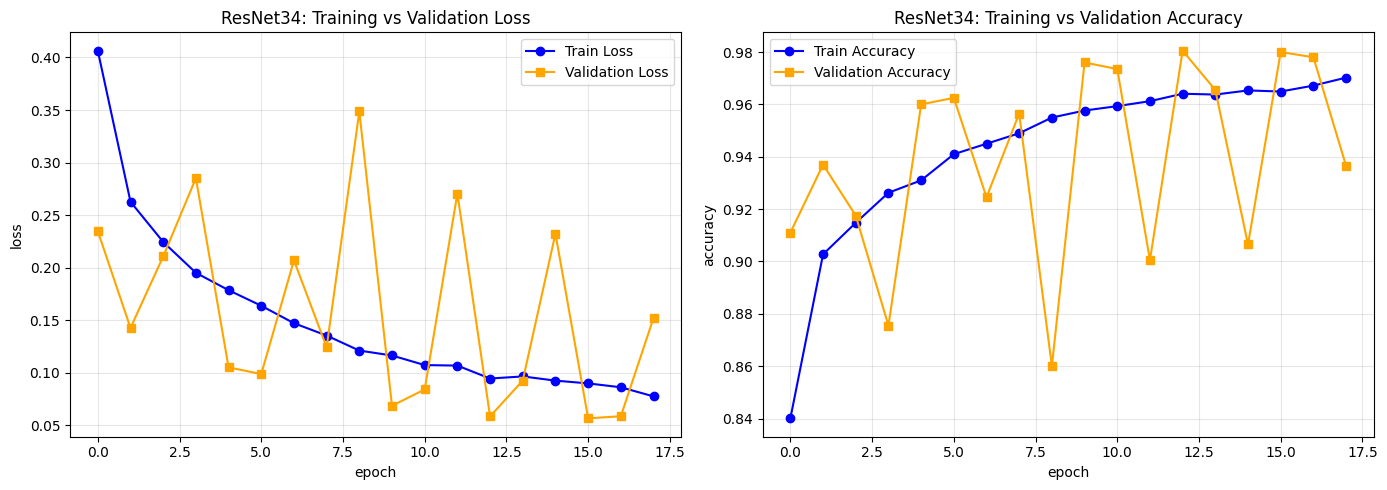

In [9]:
trainlosses = np.array([stat["trainloss"] for stat in stats_resnet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_resnet])
vallosses = np.array([stat["valloss"] for stat in stats_resnet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_resnet])
epochs = np.array([stat["epoch"] for stat in stats_resnet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("ResNet34: Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("ResNet34: Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/resnet_final_training_curves.png", dpi=150, bbox_inches='tight')
print("✅ ResNet graph saved to outputs/resnet_final_training_curves.png")
plt.show()
